# Primera Parte: Análisis Cuantitativo

## 1.1	Primer examen preliminar del dataset.  ¿En qué formato está el dataset y qué tiene que ver este formato con Big Data? ¿Qué parámetros hay en el dataset? ¿Cuál es su significado? ¿Existen valores aparentemente incorrectos?

### Instalar los paquetes necesarios, ejecutar solo al principio.

In [120]:
# 📦 Instalar paquetes necesarios
%pip install pandas numpy pyarrow matplotlib seaborn plotly nbformat scipy scikit-learn pyspark


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importar librerías

In [121]:
# 📦 Imports principales para análisis de datos y visualización

# Carga y manipulación de datos
import pandas as pd       # type: ignore # Manipulación y análisis de datos tabulares
import numpy as np        # type: ignore # Operaciones numéricas (opcional, pero útil)

# Lectura de archivos Parquet
import pyarrow.parquet as pq  # type: ignore # Backend recomendado para parquet (alternativa: fastparquet)

# Visualización básica y exploratoria
import matplotlib.pyplot as plt      # type: ignore # Visualizaciones estándar (histogramas, scatter, etc.)
import seaborn as sns                # type: ignore # Visualización estadística avanzada (heatmaps, countplots)

# Visualización avanzada 
import plotly.express as px         # type: ignore # Visualizaciones interactivas (incl. Sankey, mapas, etc.)
import plotly.graph_objects as go # type: ignore # Gráficos más complejos y personalizados

# Configuración general de visualizaciones
plt.style.use('seaborn-v0_8')        # Estilo visual estándar
# %matplotlib inline                   # Para visualizar directamente en el notebook

# Para calcular el z-score de las columnas numéricas
from scipy.stats import zscore # type: ignore

# Para manejar rutas de archivos y directorios
import os

# linear models para regresión
from sklearn.linear_model import RANSACRegressor, LinearRegression # type: ignore

# Para manejar el entorno de Spark
from pyspark.sql import SparkSession # type: ignore
from pyspark.sql.functions import col, when, isnull, lit, mean, median, count, udf  # type: ignore
from pyspark.sql.types import BooleanType, FloatType # type: ignore
from pyspark.sql.window import Window # type: ignore
import pyspark.sql.functions as F # type: ignore
from datetime import datetime



### Carga los nombres de zona desde taxi_zone_lookup.csv en zona_nombres

In [122]:
def get_zona_nombres():
    """
    Devuelve un diccionario {LocationID: Zone} con los nombres de zona de NYC.
    1. Si el archivo local 'original_parquets/taxi_zone_lookup.csv' existe, lo carga desde ahí.
    2. Si no existe, lo descarga de la URL y lo guarda localmente para futuras ejecuciones.
    """
    local_path = "original_parquets/taxi_zone_lookup.csv"
    url_lookup = "https://raw.githubusercontent.com/renerubio/NYC-TAXI/refs/heads/main/original_parquets/taxi_zone_lookup.csv"

    if os.path.exists(local_path):
        taxi_zones = pd.read_csv(local_path)
        print("Cargado desde archivo local.")
    else:
        taxi_zones = pd.read_csv(url_lookup)
        print("Cargado desde URL.")
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        taxi_zones.to_csv(local_path, index=False)
        print(f"Guardado en {local_path}.")

    return taxi_zones.set_index("LocationID")["Zone"].to_dict()

# Cargar diccionario
zona_nombres = get_zona_nombres()


Cargado desde archivo local.


### Importar y cargar ficheros parquet

In [123]:
# Función reutilizable para cargar Parquet desde local o URL
def cargar_parquet_local_o_url(local_path: str, url: str) -> pd.DataFrame:
    import os
    import pandas as pd

    if os.path.exists(local_path):
        print(f"✅ Cargado desde archivo local: {local_path}")
    else:
        print(f"🌐 Descargando desde URL: {url}")
        df = pd.read_parquet(url, engine="pyarrow")
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        df.to_parquet(local_path, engine="pyarrow", index=False)
        print(f"💾 Guardado en {local_path}")
        return df

    return pd.read_parquet(local_path, engine="pyarrow")

# Ruta base de trip-data
data_path = "https://d37ci6vzurychx.cloudfront.net/trip-data/"

# Diccionario de datasets y sus rutas
datasets_routes = {
    "yellow_df_2024_02": ("original_parquets/yellow_tripdata_2024-02.parquet", data_path + "yellow_tripdata_2024-02.parquet"),
    "green_df_2024_02":  ("original_parquets/green_tripdata_2024-02.parquet",  data_path + "green_tripdata_2024-02.parquet"),
    "yellow_df_2024_12": ("original_parquets/yellow_tripdata_2024-12.parquet", data_path + "yellow_tripdata_2024-12.parquet"),
    "green_df_2024_12":  ("original_parquets/green_tripdata_2024-12.parquet",  data_path + "green_tripdata_2024-12.parquet"),
}

# Cargar todos los datasets
for nombre, (ruta_local, url_remota) in datasets_routes.items():
    globals()[nombre] = cargar_parquet_local_o_url(ruta_local, url_remota)


✅ Cargado desde archivo local: original_parquets/yellow_tripdata_2024-02.parquet
✅ Cargado desde archivo local: original_parquets/green_tripdata_2024-02.parquet
✅ Cargado desde archivo local: original_parquets/yellow_tripdata_2024-12.parquet
✅ Cargado desde archivo local: original_parquets/green_tripdata_2024-12.parquet


### Objeto global con los datasets cargados y listos para usar 

In [124]:
# Definimos todos los datasets con sus nombres
original_datasets = {
    "yellow_tripdata_2024-02": yellow_df_2024_02, # type: ignore
    "green_tripdata_2024-02": green_df_2024_02, # type: ignore
    "yellow_tripdata_2024-12": yellow_df_2024_12, # type: ignore
    "green_tripdata_2024-12": green_df_2024_12, # type: ignore
}

# Liberar memoria de las variables ya cargadas
del yellow_df_2024_02 # type: ignore
del green_df_2024_02 # type: ignore
del yellow_df_2024_12 # type: ignore
del green_df_2024_12 # type: ignore


## Análisis de datos

### Obtener todas las columnas y su frecuencia
Al haber diferentes nombres en las columnas las visualizamos en un heatmap
0.8seg

C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_17220\3950756203.py:34: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



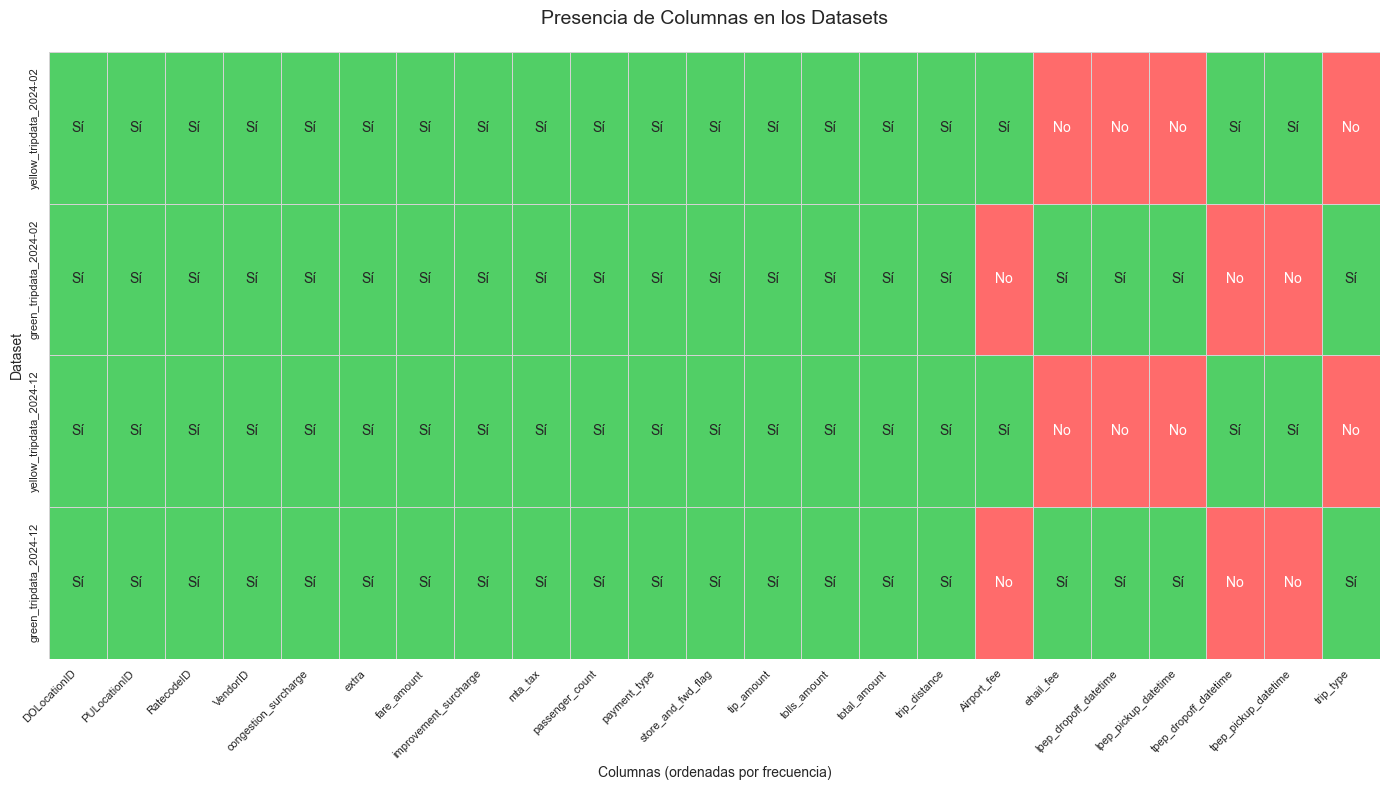

In [125]:
def plot_column_presence_heatmap(datasets):
    """
    Genera un heatmap de presencia de columnas a partir de un diccionario de datasets.

    :param datasets: Diccionario con claves como nombres de dataset y valores como DataFrames
    """

    # 1. Obtener todas las columnas y su frecuencia
    all_columns = set()
    for df in datasets.values():
        all_columns.update(df.columns)
    column_freq = {col: sum(col in df.columns for df in datasets.values()) for col in all_columns}

    # 2. Ordenar columnas por frecuencia (de mayor a menor)
    sorted_columns = sorted(all_columns, key=lambda x: (-column_freq[x], x))

    # 3. Crear matriz de presencia (Sí/No)
    presence_matrix = []
    for name, df in datasets.items():
        presences = [1 if col in df.columns else 0 for col in sorted_columns]
        presences = ["Sí" if p == 1 else "No" for p in presences]
        presence_matrix.append(presences)

    # 4. Crear DataFrame para el heatmap
    heatmap_df = pd.DataFrame(
        presence_matrix,
        index=datasets.keys(),
        columns=sorted_columns
    )

    # 5. Configurar el gráfico
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        heatmap_df.replace({"Sí": 1, "No": 0}),
        cmap=["#FF6B6B", "#51CF66"],
        linewidths=0.5,
        linecolor="lightgray",
        annot=heatmap_df.values,
        fmt="",
        cbar=False
    )

    # 6. Personalizar el gráfico
    plt.title("Presencia de Columnas en los Datasets", fontsize=14, pad=20)
    plt.xlabel("Columnas (ordenadas por frecuencia)", fontsize=10)
    plt.ylabel("Dataset", fontsize=10)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(fontsize=8)

    plt.tight_layout()
    plt.show()
plot_column_presence_heatmap(original_datasets)


## Renombrar columnas/atributos

### Objeto global `column_groups` son grupos de columnas equivalentes el renombrado

In [126]:
# Grupos de columnas equivalentes para el renombrado
column_groups = {
    # Columnas de ubicación (zonas)
    'PULocationID': ['PUlocationID', 'PULocationID', 'pickup_zone', 'PU_zone'],
    'DOLocationID': ['DOlocationID', 'DOLocationID', 'dropoff_zone', 'DO_zone'],

    # Columnas de ubicación (coordenadas)
    'Start_Lon': ['Start_Lon', 'pickup_longitude', 'start_lon', 'pickup_lon'],
    'Start_Lat': ['Start_Lat', 'pickup_latitude', 'start_lat', 'pickup_lat'],
    'End_Lon': ['End_Lon', 'dropoff_longitude', 'end_lon', 'dropoff_lon'],
    'End_Lat': ['End_Lat', 'dropoff_latitude', 'end_lat', 'dropoff_lat'],

    # Columnas temporales
    'pickup_datetime': [
        'tpep_pickup_datetime', 'lpep_pickup_datetime',
        'pickup_datetime', 'Trip_Pickup_DateTime',
        'request_datetime'
    ],
    'dropoff_datetime': [
        'tpep_dropoff_datetime', 'lpep_dropoff_datetime',
        'dropoff_datetime', 'dropOff_datetime', 'on_scene_datetime',
        'Trip_Dropoff_DateTime'
    ],

    # Columnas de distancia
    'trip_distance': [
        'trip_distance', 'Trip_distance', 'Trip_Distance',
        'distance', 'trip_miles', 'Distance'
    ],

    # Columnas de importe total
    'total_amount': ['total_amount', 'Total_Amt', 'Total_amount', 'total_amt', 'total fare', 'fare'],

    # Columnas de tarifa base
    'fare_amount': ['fare_amount', 'Fare_Amt', 'fare_amt', 'Fare', 'fare'],

    # Columnas de tarifas
    'airport_fee': ['airport_fee', 'Airport_fee', 'airportFee'],
    'extra': ['extra', 'surcharge', 'Extra', 'extra_charge'],

    # Columnas de pago
    'tolls': ['tolls_amount', 'tolls', 'Tolls_Amt', 'toll', 'Tolls'],
    'tips': ['tip_amount', 'tips', 'Tip_Amt', 'Tip', 'Tips'],
    'payment_type': ['payment_type', 'Payment_Type', 'paymenttype', 'pay_type'],

    # Columnas de código de tarifa
    'RatecodeID': ['RatecodeID', 'Rate_Code', 'rate_code', 'Rate_Code_ID'],

    # Columnas de ID de proveedor
    'VendorID': ['VendorID', 'vendor_name', 'vendorid', 'Vendor_Id'],

    # Columnas de número de pasajeros
    'passenger_count': ['passenger_count', 'Passenger_Count', 'passengers', 'passenger', 'num_passengers'],

    # Columnas de store and forward
    'store_and_fwd_flag': ['store_and_fwd_flag', 'store_and_forward', 'store_fwd_flag', 'store_flag'],

    # Columnas especiales de FHV y FHVHV
    'base_number': [
        'dispatching_base_num', 'Affiliated_base_number',
        'originating_base_num', 'hvfhs_license_num', 'base_number'
    ],
}

### Renombrar los parámetros para tener uniformidad para los futuros análisis (50seg ~ 2min)
- Renombra columnas en cada dataset según el diccionario column_groups.
- Añade same_location_flag cuando el punto de recogida y destino son iguales.
- Añade suspicious_location_flag si además la distancia es 0 o el total_amount es muy alto (umbral > 1000$).

In [127]:
def rename_column_names_with_flags(datasets_dict, column_mapping):
    """
    Renombra columnas a su estándar y agrega flags de localización.
    Es compatible con datasets con zonas (PULocationID/DOLocationID) y solo coordenadas.

    - same_location_flag: True si PULocationID == DOLocationID o si las coordenadas de origen y destino son iguales.
    - suspicious_location_flag: True si misma localización y (trip_distance == 0 o total_amount > umbral)
    - Ordena columnas según el orden de column_mapping + flags al final

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}
        column_mapping: mapeo de nombres estándar a variantes

    Retorna:
        diccionario con DataFrames normalizados y enriquecidos con flags
    """
    datasets_renombrados = {}

    # Orden estándar: todos los keys del mapping en orden + flags al final
    orden_base = list(column_mapping.keys()) + ["same_location_flag", "suspicious_location_flag"]

    for nombre, df in datasets_dict.items():
        df = df.copy()

        # 1. Renombra columnas
        for standard_name, variants in column_mapping.items():
            for variant in variants:
                if variant in df.columns:
                    if standard_name in df.columns and variant != standard_name:
                        df.drop(columns=[variant], inplace=True)
                    else:
                        df.rename(columns={variant: standard_name}, inplace=True)

        # 2. Elimina duplicadas
        df = df.loc[:, ~df.columns.duplicated()]

        # 3. Flags de localización
        if "PULocationID" in df.columns and "DOLocationID" in df.columns:
            df["same_location_flag"] = df["PULocationID"] == df["DOLocationID"]

            if "trip_distance" in df.columns and "total_amount" in df.columns:
                df["suspicious_location_flag"] = (
                    (df["same_location_flag"]) &
                    ((df["trip_distance"] == 0) | (df["total_amount"] > 1000))
                )
            else:
                df["suspicious_location_flag"] = False

        # Si no hay zonas pero sí coordenadas (soporta datasets antiguos tipo 2009)
        elif all(col in df.columns for col in ["Start_Lon", "Start_Lat", "End_Lon", "End_Lat"]):
            df["same_location_flag"] = (
                (df["Start_Lon"] == df["End_Lon"]) &
                (df["Start_Lat"] == df["End_Lat"])
            )
            if "trip_distance" in df.columns and "total_amount" in df.columns:
                df["suspicious_location_flag"] = (
                    (df["same_location_flag"]) &
                    ((df["trip_distance"] == 0) | (df["total_amount"] > 1000))
                )
            else:
                df["suspicious_location_flag"] = False
        else:
            df["same_location_flag"] = False
            df["suspicious_location_flag"] = False

        # 4. Ordena columnas según orden_base
        columnas_existentes = [col for col in orden_base if col in df.columns]
        columnas_extra = [col for col in df.columns if col not in columnas_existentes]
        df = df[columnas_existentes + columnas_extra]

        datasets_renombrados[nombre] = df

    return datasets_renombrados


renamed_datasets = rename_column_names_with_flags(original_datasets, column_groups)



### Heatmap antes y después de renombrar columnas
0.9seg

C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_17220\3950756203.py:34: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



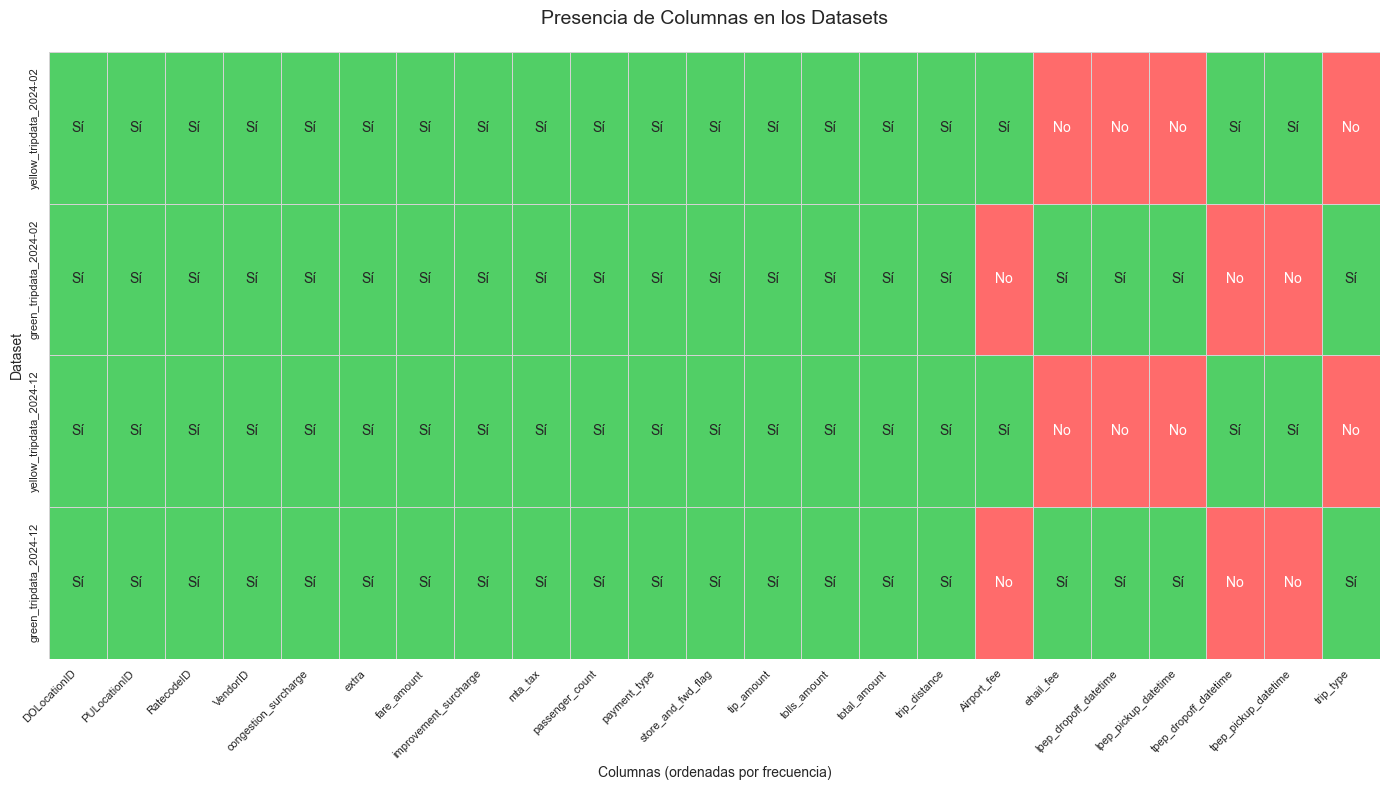

C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_17220\3950756203.py:34: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



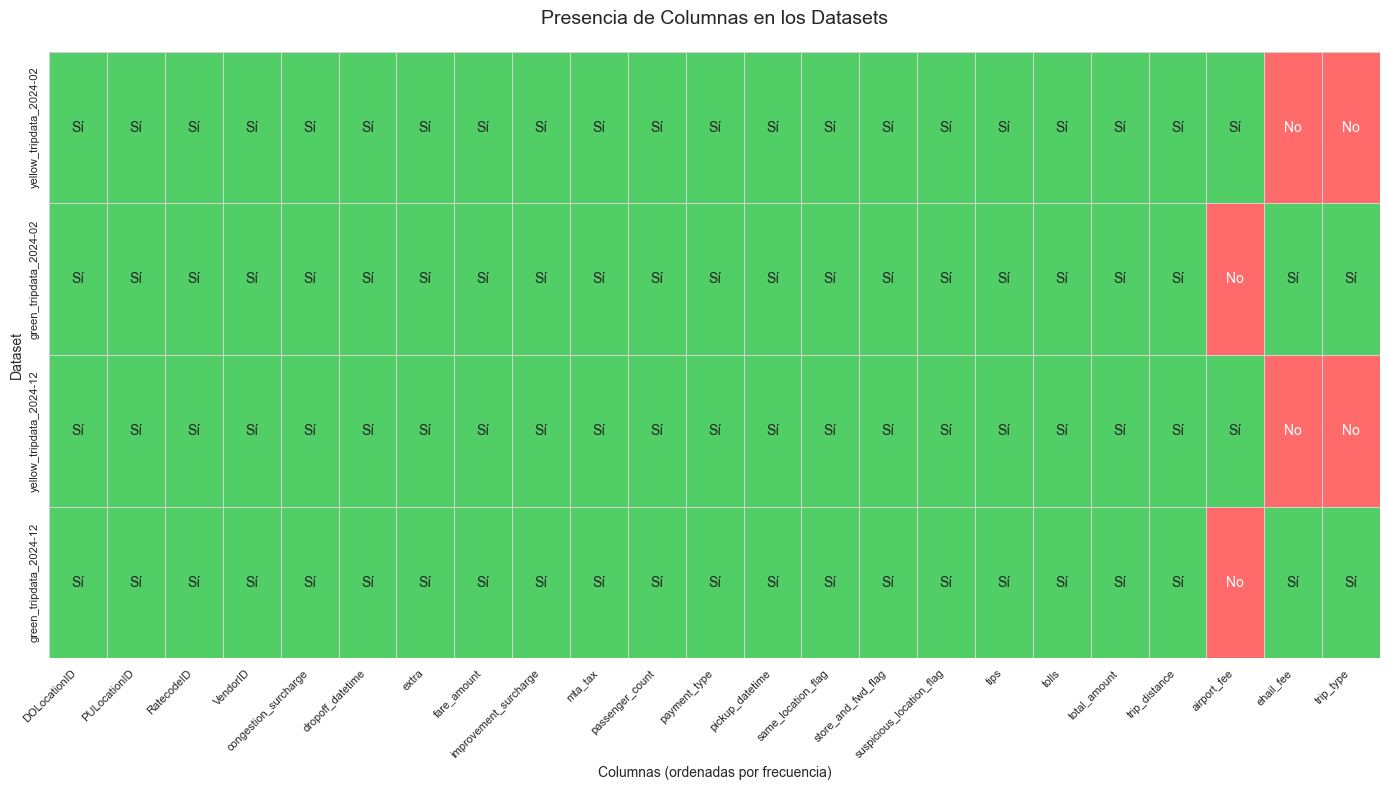

In [128]:
# heatmap de columnas antes de renombrar columnas
plot_column_presence_heatmap(original_datasets)
# heatmap de columnas después de renombrar columnas
plot_column_presence_heatmap(renamed_datasets)

### Guardado en parquet unificado 

In [129]:
# Guardar datasets renombrados
def guardar_parquets_unificados(datasets_dict, carpeta_salida="unified_parquets"):
    """
    Une los datasets yellow y green por mes (ignorando 2009) y guarda en formato Parquet.

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}
        carpeta_salida: carpeta donde guardar los Parquet
    """
    os.makedirs(carpeta_salida, exist_ok=True)

    # Detección automática de los pares yellow/green
    meses = ["2024-02", "2024-12"]

    for mes in meses:
        yellow_key = f"yellow_tripdata_{mes}"
        green_key = f"green_tripdata_{mes}"

        if yellow_key in datasets_dict and green_key in datasets_dict:
            df_yellow = datasets_dict[yellow_key]
            df_green = datasets_dict[green_key]

            # Unión ignorando columnas que falten (en pandas)
            df_unificado = pd.concat([df_yellow, df_green], ignore_index=True, sort=False)

            # Ruta de salida
            ruta_salida = os.path.join(carpeta_salida, f"taxis_tripdata_{mes}.parquet")

            # Guardado
            df_unificado.to_parquet(ruta_salida, index=False)
            print(f"✅ Guardado: {ruta_salida}")
        else:
            print(f"⚠️  No se encontraron ambos datasets para {mes}, se omite.")

guardar_parquets_unificados(renamed_datasets)


✅ Guardado: unified_parquets\taxis_tripdata_2024-02.parquet
✅ Guardado: unified_parquets\taxis_tripdata_2024-12.parquet


### Unificación de datasets

In [130]:
taxis_df_2024_02 = pd.concat([
    renamed_datasets["yellow_tripdata_2024-02"],
    renamed_datasets["green_tripdata_2024-02"]
], ignore_index=True, sort=False)

taxis_df_2024_12 = pd.concat([
    renamed_datasets["yellow_tripdata_2024-12"],
    renamed_datasets["green_tripdata_2024-12"]
], ignore_index=True, sort=False)

## Limpieza de Datos

### Limpieza de datos con pandas

In [131]:
def limpiar_dataset_integrado(datasets_dict, zona_nombres=None, min_freq=5):
    """
    Limpieza y validación exhaustiva de los datasets de trayectos NYC Taxi, robusta ante diferentes formatos y años.

    Incorpora imputación, filtrado de outliers, validaciones de coherencia,
    y enriquecimiento de variables temporales y tarifarias.
    Soporta datasets con columnas de zonas (PULocationID/DOLocationID) o solo coordenadas (Start_Lon, Start_Lat, End_Lon, End_Lat).

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}
        zona_nombres: diccionario {zone_id: nombre_zona} (opcional)
        min_freq: frecuencia mínima para imputación local

    Retorna:
        Diccionario con los DataFrames corregidos y enriquecidos.
    """
    datasets_corregidos = {}

    for nombre, df in datasets_dict.items():
        try:
            print(f"\n🔄 Procesando: {nombre}")
            df = df.copy()
            flags = []

            # --- 1. Detectar columnas estándar o alternativas con column_groups ---
            col = lambda grupo: next((c for c in column_groups[grupo] if c in df.columns), grupo if grupo in df.columns else None)
            col_pickup = col('pickup_datetime')
            col_dropoff = col('dropoff_datetime')
            col_total = col('total_amount')
            col_dist = col('trip_distance')
            col_pu = col('PULocationID')
            col_do = col('DOLocationID')
            col_start_lon = col('Start_Lon')
            col_start_lat = col('Start_Lat')
            col_end_lon = col('End_Lon')
            col_end_lat = col('End_Lat')
            col_passengers = col('passenger_count')

            # --- 2. Validación de columnas requeridas ---
            required_cols = [col_pickup, col_dropoff, col_total, col_dist]
            if any(c is None for c in required_cols):
                print(f"⚠️ {nombre}: faltan columnas mínimas requeridas. Se omite.")
                continue

            # --- 3. Convertir fechas ---
            df[col_pickup] = pd.to_datetime(df[col_pickup], errors="coerce")
            df[col_dropoff] = pd.to_datetime(df[col_dropoff], errors="coerce")

            # --- 4. Validación geográfica flexible ---
            tiene_zonas = col_pu is not None and col_do is not None and zona_nombres is not None
            tiene_coords = all(c is not None for c in [col_start_lon, col_start_lat, col_end_lon, col_end_lat])

            if tiene_zonas:
                mask_zonas_validas = (
                    df[col_pu].notnull() & df[col_do].notnull() &
                    df[col_pu].astype("Int64").isin(zona_nombres.keys()) &
                    df[col_do].astype("Int64").isin(zona_nombres.keys())
                )
                flags.append(mask_zonas_validas)
                df["key"] = list(zip(df[col_pu], df[col_do]))
            elif tiene_coords:
                mask_coords_validas = (
                    df[col_start_lon].notnull() & df[col_start_lat].notnull() &
                    df[col_end_lon].notnull() & df[col_end_lat].notnull() &
                    ~df.get("suspicious_location_flag", False)
                )
                flags.append(mask_coords_validas)
                df["key"] = list(zip(df[col_start_lon], df[col_start_lat], df[col_end_lon], df[col_end_lat]))
            else:
                print(f"⚠️ {nombre}: No se detectan ni columnas de zona ni de coordenadas. Se omite.")
                continue

            # --- 5. Imputación local de distancias ---
            mask_td = df[col_dist].isnull() | (df[col_dist] <= 0)
            valid_td = df.loc[~mask_td].copy()
            freq = valid_td.groupby("key").size()
            comunes = freq[freq >= min_freq].index
            medianas_td = valid_td.groupby("key")[col_dist].median()
            def imputar_td(row):
                if row["key"] in comunes:
                    return medianas_td[row["key"]]
                return None
            df.loc[mask_td, col_dist] = df.loc[mask_td].apply(imputar_td, axis=1)
            flags.append(~df[col_dist].isnull())

            # --- 6. Filtro: Distancia realista ---
            flags.append((df[col_dist] >= 0.3) & (df[col_dist] <= 50))

            # --- 7. Cálculo de duración de trayecto en minutos ---
            if "trip_duration_min" not in df.columns:
                df["trip_duration_min"] = (df[col_dropoff] - df[col_pickup]).dt.total_seconds() / 60

            # --- 8. Filtro: Duración realista ---
            mask_dur = df["trip_duration_min"].notnull() & (df["trip_duration_min"] > 0) & (df["trip_duration_min"] <= 180)
            flags.append(mask_dur)

            # --- 9. Filtro: Precio total positivo ---
            mask_amt = df[col_total].notnull() & (df[col_total] > 0)
            flags.append(mask_amt)

            # --- 10. Filtro: Velocidad media realista (2 < v < 100 km/h) ---
            df["velocidad_media_kmh"] = (df[col_dist] * 1.60934) / (df["trip_duration_min"] / 60)
            flags.append((df["velocidad_media_kmh"] >= 2) & (df["velocidad_media_kmh"] <= 100))

            # --- 11. Filtro: Precio real/teórico coherente ---
            tarifa_inicial = 3.00
            tarifa_milla = 2.50
            tarifa_minuto = 0.70
            df["precio_teorico_estimado"] = (
                tarifa_inicial +
                df[col_dist] * tarifa_milla +
                df["trip_duration_min"] * tarifa_minuto
            )
            df["precio_ratio"] = df[col_total] / df["precio_teorico_estimado"]
            flags.append((df["precio_ratio"] < 3) & (df["precio_ratio"] > 0.3))

            # --- 12. Filtro: Origen y destino distintos ---
            if tiene_zonas:
                flags.append(df[col_pu] != df[col_do])
            elif tiene_coords:
                flags.append(
                    (df[col_start_lon] != df[col_end_lon]) | (df[col_start_lat] != df[col_end_lat])
                )

            # --- 13. Imputación local de pasajeros (si existe) ---
            if col_passengers is not None:
                mask_pc = df[col_passengers].isnull() | (df[col_passengers] < 0)
                if mask_pc.any():
                    medianas_pc = df.loc[~mask_pc].groupby("key")[col_passengers].median()
                    df.loc[mask_pc, col_passengers] = df.loc[mask_pc, "key"].map(medianas_pc)
                flags.append(~df[col_passengers].isnull())

            # --- 14. Filtro crítico: minutos por kilómetro realistas ---
            df["min_per_km"] = df["trip_duration_min"] / (df[col_dist] * 1.60934)
            flags.append(df["min_per_km"] <= 20)

            # --- 15. Enriquecimiento temporal: hora, día y hora pico ---
            df["Hora"] = df[col_pickup].dt.hour
            df["Dia"] = df[col_pickup].dt.day_name()
            df['Hora_Pico'] = df['Hora'].apply(lambda x: 1 if (7 <= x < 10) or (16 <= x < 19) else 0)

            # --- 16. Tarifa mínima NYC: ---
            df["Precio ($)"] = df[col_total]
            df.loc[df["trip_duration_min"] < 2, "Precio ($)"] = 7.00

            # --- 17. Filtro adicional: precio total mínimo ---
            df = df[df["Precio ($)"] >= 2.00]

            # --- 18. Filtro de outliers por precio/minuto ---
            df["$/min"] = df["Precio ($)"] / df["trip_duration_min"]
            df = df[df["$/min"] <= 5]

            # --- 19. Filtro reforzado: Precio por km realista ---
            df["fare_per_km"] = df["Precio ($)"] / (df[col_dist] * 1.60934)
            df = df[(df["fare_per_km"] >= 0.2) & (df["fare_per_km"] <= 100)]

            # --- 20. (Opcional) Validación de pagos, tips, tolls, mta_tax, etc. ---
            if "payment_type" in df.columns:
                df = df[df["payment_type"].notnull()]
            if "tips" in df.columns:
                df["tips"] = df["tips"].fillna(0)
            if "tolls" in df.columns:
                df["tolls"] = df["tolls"].fillna(0)
            if "mta_tax" in df.columns:
                df["mta_tax"] = df["mta_tax"].fillna(0)

            # --- Aplicación final de los flags ---
            df["flag_limpieza"] = flags[0]
            for f in flags[1:]:
                df["flag_limpieza"] &= f

            df_final = df[df["flag_limpieza"]].copy()
            df_final.drop(
                columns=["key", "flag_limpieza", "velocidad_media_kmh", "min_per_km", "$/min"],
                inplace=True,
                errors="ignore"
            )

            datasets_corregidos[nombre] = df_final
            print(f"✅ {nombre}: limpieza completada con {len(df_final)} registros válidos.")

        except Exception as e:
            print(f"❌ Error procesando {nombre}: {e}")
            continue

    return datasets_corregidos


# aplicar limpieza a los datasets renombrados por separado
cleaned_separated_datasets = limpiar_dataset_integrado(renamed_datasets, zona_nombres)

# Aplicar limpieza a los datasets renombrados
unified_datasets = {
    "taxis_tripdata_2024-02": taxis_df_2024_02,
    "taxis_tripdata_2024-12": taxis_df_2024_12
}
# Aplicar limpieza a los datasets renombrados
cleaned_datasets = limpiar_dataset_integrado(unified_datasets, zona_nombres)


🔄 Procesando: yellow_tripdata_2024-02


C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_17220\367459610.py:170: FutureWarning:

Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.



✅ yellow_tripdata_2024-02: limpieza completada con 2778554 registros válidos.

🔄 Procesando: green_tripdata_2024-02


C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_17220\367459610.py:170: FutureWarning:

Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.



✅ green_tripdata_2024-02: limpieza completada con 42664 registros válidos.

🔄 Procesando: yellow_tripdata_2024-12


C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_17220\367459610.py:170: FutureWarning:

Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.



✅ yellow_tripdata_2024-12: limpieza completada con 3304176 registros válidos.

🔄 Procesando: green_tripdata_2024-12


C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_17220\367459610.py:170: FutureWarning:

Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.



✅ green_tripdata_2024-12: limpieza completada con 43605 registros válidos.

🔄 Procesando: taxis_tripdata_2024-02


C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_17220\367459610.py:170: FutureWarning:

Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.



✅ taxis_tripdata_2024-02: limpieza completada con 2822177 registros válidos.

🔄 Procesando: taxis_tripdata_2024-12


C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_17220\367459610.py:170: FutureWarning:

Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.



✅ taxis_tripdata_2024-12: limpieza completada con 3349417 registros válidos.


### Guardar los datasets limpios en parquet

In [132]:
# Guardar datasets renombrados
def guardar_datasets_limpios(datasets_dict, carpeta_salida="cleaned_parquets", guardar_csv=False):
    """
    Guarda cada DataFrame del diccionario en formato Parquet dentro de la carpeta especificada.
    
    Opcionalmente, también guarda cada DataFrame como CSV.

    Parámetros:
        datasets_dict: dict[str, pd.DataFrame] - Diccionario {nombre_dataset: DataFrame}
        carpeta_salida: str - Carpeta donde guardar los archivos .parquet
        guardar_csv: bool - Si True, también guarda cada archivo como .csv
    """
    os.makedirs(carpeta_salida, exist_ok=True)

    for nombre, df in datasets_dict.items():
        if not isinstance(df, pd.DataFrame):
            print(f"❌ El valor asociado a '{nombre}' no es un DataFrame. Se omite.")
            continue

        try:
            nombre_archivo = f"{nombre}.parquet"
            ruta_parquet = os.path.join(carpeta_salida, nombre_archivo)
            df.to_parquet(ruta_parquet, index=False)
            print(f"✅ Guardado Parquet: {ruta_parquet}")

            if guardar_csv:
                nombre_csv = f"{nombre}.csv"
                ruta_csv = os.path.join(carpeta_salida, nombre_csv)
                df.to_csv(ruta_csv, index=False)
                print(f"📄 Guardado CSV: {ruta_csv}")

        except Exception as e:
            print(f"❌ Error al guardar '{nombre}': {e}")

guardar_datasets_limpios(cleaned_datasets)


✅ Guardado Parquet: cleaned_parquets\taxis_tripdata_2024-02.parquet
✅ Guardado Parquet: cleaned_parquets\taxis_tripdata_2024-12.parquet


### (Opcional) - Cargar todos los datasets *.parquet limpios en un diccionario 
Es opcional si ya los tenemos creados, podríamos cargarlos directamente en vez de pasar todo el proceso de renombrado, limpieza, unificación y guardado.

In [133]:
def cargar_datasets_parquet(carpeta="cleaned_parquets"):
    """
    Carga los archivos .parquet uno a uno desde la carpeta especificada
    y los guarda en un diccionario con nombres legibles.

    Evita problemas de memoria al no cargar todos simultáneamente.
    """
    datasets = {}
    for archivo in os.listdir(carpeta):
        if archivo.endswith(".parquet"):
            nombre_dataset = archivo.replace(".parquet", "")
            ruta = os.path.join(carpeta, archivo)
            try:
                print(f"📥 Cargando: {nombre_dataset}")
                df = pd.read_parquet(ruta)
                datasets[nombre_dataset] = df
            except Exception as e:
                print(f"⚠️ Error al cargar {nombre_dataset}: {e}")
    return datasets

# Cargar los datasets renombrados desde parquet
""" renamed_datasets = cargar_datasets_parquet("datasets_limpios") """
# Verificar la carga
""" for name, df in renamed_datasets.items():
    print(f"{name}: {df.shape[0]:,} filas, {df.shape[1]} columnas") """

' for name, df in renamed_datasets.items():\n    print(f"{name}: {df.shape[0]:,} filas, {df.shape[1]} columnas") '

### ¿Existen valores aparentemente incorrectos?
Analiza todos los DataFrames en un diccionario (como cleaned_datasets). La función evalúa los mismos valores inválidos y genera un resumen por dataset.

In [134]:
# Verificación de calidad de columnas
def analizar_valores_invalidos_dict(datasets_dict, zona_nombres=None):
    """
    Analiza valores inválidos en un diccionario de datasets (DataFrames).

    Evalúa:
    - Valores nulos o incoherentes en pasajeros, distancia, importe, duración, zonas o coordenadas.
    - Detecta automáticamente si el dataset usa zonas o solo coordenadas (compatibilidad total).
    - Si no hay zonas, valida coordenadas y flags de localización sospechosa si existen.

    Devuelve:
        Un DataFrame resumen con el conteo de errores por tipo y dataset.
    """

    resumen = []

    for nombre, df in datasets_dict.items():
        resultados = {}
        print(f"🔍 Analizando: {nombre}")

        # Helper para encontrar la primera columna disponible según el mapping
        def col(grupo):
            return next((c for c in column_groups[grupo] if c in df.columns), grupo if grupo in df.columns else None)

        col_passengers = col('passenger_count')
        col_distance = col('trip_distance')
        col_total = col('total_amount')
        col_pickup = col('pickup_datetime')
        col_dropoff = col('dropoff_datetime')
        col_pu = col('PULocationID')
        col_do = col('DOLocationID')
        col_start_lon = col('Start_Lon')
        col_start_lat = col('Start_Lat')
        col_end_lon = col('End_Lon')
        col_end_lat = col('End_Lat')

        # 1. Pasajeros
        if col_passengers:
            resultados['Pasajeros = nulos'] = df[col_passengers].isna().sum()
            resultados['Pasajeros < 0'] = (df[col_passengers] < 0).sum()

        # 2. Distancia
        if col_distance:
            resultados['Distancia = nula'] = df[col_distance].isna().sum()
            resultados['Distancia <= 0'] = (df[col_distance] <= 0).sum()

        # 3 y 4. Duración inválida
        if col_pickup and col_dropoff:
            pickup = pd.to_datetime(df[col_pickup], errors='coerce')
            dropoff = pd.to_datetime(df[col_dropoff], errors='coerce')
            resultados['Pickup/dropoff = nulos'] = pickup.isna().sum() + dropoff.isna().sum()
            resultados['Dropoff < Pickup'] = (dropoff < pickup).sum()
            resultados['Duración = 0 min'] = (dropoff == pickup).sum()

        # 5. Total
        if col_total:
            resultados['Total_amount = nulo'] = df[col_total].isna().sum()
            resultados['Total_amount <= 0'] = (df[col_total] <= 0).sum()

        # 6. Ubicaciones (zonas o coordenadas)
        if col_pu and zona_nombres:
            resultados['PULocationID = nulo'] = df[col_pu].isna().sum()
            resultados['PULocationID fuera de rango'] = df[~df[col_pu].isin(zona_nombres.keys())].shape[0]
        if col_do and zona_nombres:
            resultados['DOLocationID = nulo'] = df[col_do].isna().sum()
            resultados['DOLocationID fuera de rango'] = df[~df[col_do].isin(zona_nombres.keys())].shape[0]
        # Si NO hay zonas pero sí coordenadas, valida coordenadas nulas o sospechosas
        if col_start_lon and col_start_lat and col_end_lon and col_end_lat:
            resultados['Start_Lon = nulo'] = df[col_start_lon].isna().sum()
            resultados['Start_Lat = nulo'] = df[col_start_lat].isna().sum()
            resultados['End_Lon = nulo'] = df[col_end_lon].isna().sum()
            resultados['End_Lat = nulo'] = df[col_end_lat].isna().sum()
            # Flags de localización sospechosa si existen
            if 'suspicious_location_flag' in df.columns:
                resultados['suspicious_location_flag = True'] = df['suspicious_location_flag'].sum()
            if 'same_location_flag' in df.columns:
                resultados['same_location_flag = True'] = df['same_location_flag'].sum()

        # Agregar los resultados al resumen
        for k, v in resultados.items():
            resumen.append({"Dataset": nombre, "Tipo de error": k, "Nº de registros": v})

    return pd.DataFrame(resumen)

# Verificación de calidad de columnas
df_errores = analizar_valores_invalidos_dict(cleaned_datasets)
display(df_errores)

# Verificación de calidad de columnas
""" df_original_errores = analizar_valores_invalidos_dict(datasets)
display(df_original_errores) """

🔍 Analizando: taxis_tripdata_2024-02
🔍 Analizando: taxis_tripdata_2024-12


,Dataset,Tipo de error,Nº de registros
0,taxis_tripdata_2024-02,Pasajeros = nulos,0
1,taxis_tripdata_2024-02,Pasajeros < 0,0
2,taxis_tripdata_2024-02,Distancia = nula,0
3,taxis_tripdata_2024-02,Distancia <= 0,0
4,taxis_tripdata_2024-02,Pickup/dropoff = nulos,0
5,taxis_tripdata_2024-02,Dropoff < Pickup,0
6,taxis_tripdata_2024-02,Duración = 0 min,0
7,taxis_tripdata_2024-02,Total_amount = nulo,0
8,taxis_tripdata_2024-02,Total_amount <= 0,0
9,taxis_tripdata_2024-12,Pasajeros = nulos,0


' df_original_errores = analizar_valores_invalidos_dict(datasets)\ndisplay(df_original_errores) '

#### Gráfico combinado para representar de forma clara y visual los outliers en las variables más propensas a errores

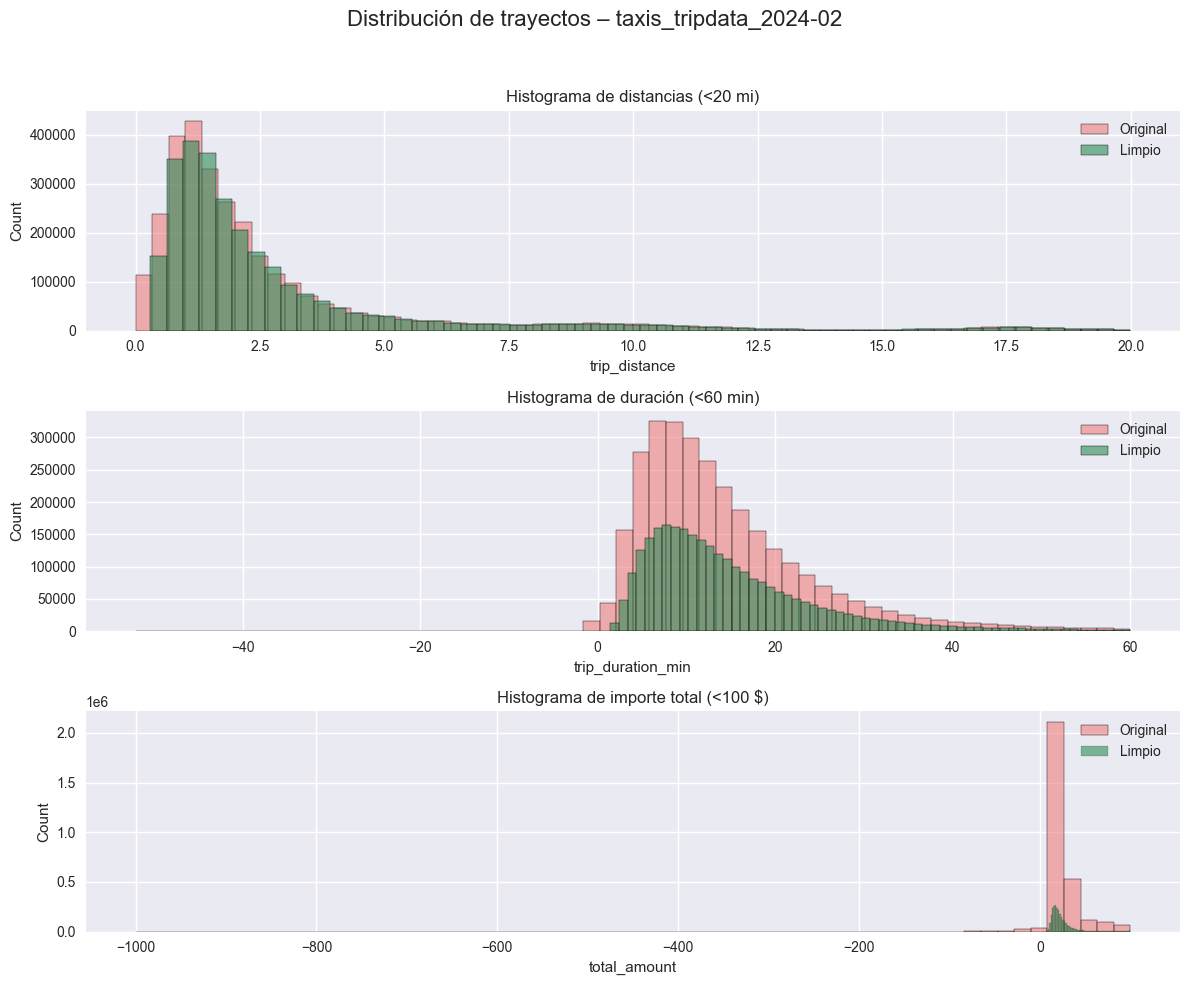

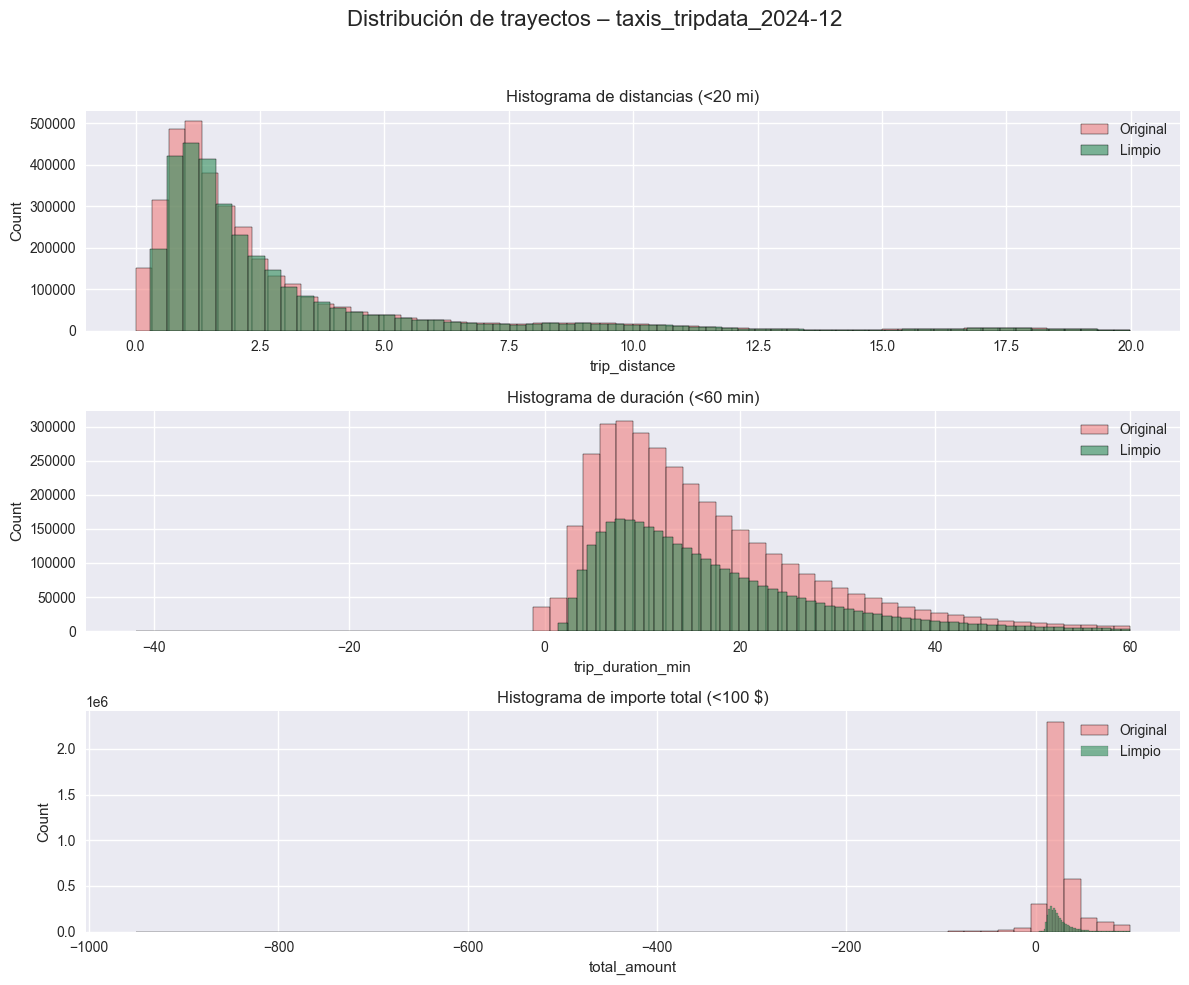

In [135]:
def comparar_outliers_multivariables(unified_datasets, limpio_dict):
    """
    Compara histogramas de distancia, duración y total_amount para datasets originales y limpios.
    Omite datasets sin las columnas requeridas.
    """
    for nombre in unified_datasets:
        if nombre not in limpio_dict:
            print(f"⚠️ {nombre} no está en el conjunto limpio. Se omite.")
            continue

        df_orig = unified_datasets[nombre].copy()
        df_limpio = limpio_dict[nombre].copy()

        # Verificar columnas necesarias
        if "trip_distance" not in df_orig.columns or "trip_distance" not in df_limpio.columns:
            print(f"⚠️ {nombre} no tiene 'trip_distance'. Se omite.")
            continue

        if "trip_duration_min" not in df_orig.columns:
            pickup_cols = [c for c in ['tpep_pickup_datetime', 'lpep_pickup_datetime', 'pickup_datetime'] if c in df_orig.columns]
            dropoff_cols = [c for c in ['tpep_dropoff_datetime', 'lpep_dropoff_datetime', 'dropoff_datetime', 'dropOff_datetime'] if c in df_orig.columns]
            if pickup_cols and dropoff_cols:
                df_orig["trip_duration_min"] = (
                    pd.to_datetime(df_orig[dropoff_cols[0]], errors="coerce") -
                    pd.to_datetime(df_orig[pickup_cols[0]], errors="coerce")
                ).dt.total_seconds() / 60

        if "trip_duration_min" not in df_limpio.columns and "trip_duration_min" in df_orig.columns:
            df_limpio["trip_duration_min"] = df_orig["trip_duration_min"]

        if "trip_duration_min" not in df_orig.columns or "trip_duration_min" not in df_limpio.columns:
            print(f"⚠️ {nombre} no tiene 'trip_duration_min'. Se omite.")
            continue

        if "total_amount" not in df_orig.columns or "total_amount" not in df_limpio.columns:
            print(f"⚠️ {nombre} no tiene 'total_amount'. Se omite.")
            continue

        # Filtrado para visualización
        df_orig = df_orig[
            (df_orig["trip_distance"] < 20) &
            (df_orig["trip_duration_min"] < 60) &
            (df_orig["total_amount"] < 100)
        ]
        df_limpio = df_limpio[
            (df_limpio["trip_distance"] < 20) &
            (df_limpio["trip_duration_min"] < 60) &
            (df_limpio["total_amount"] < 100)
        ]

        # Visualización
        fig, axs = plt.subplots(3, 1, figsize=(12, 10))
        fig.suptitle(f"Distribución de trayectos – {nombre}", fontsize=16)

        # Distancia
        sns.histplot(df_orig["trip_distance"], bins=60, color="lightcoral", label="Original", ax=axs[0], alpha=0.6)
        sns.histplot(df_limpio["trip_distance"], bins=60, color="seagreen", label="Limpio", ax=axs[0], alpha=0.6)
        axs[0].set_title("Histograma de distancias (<20 mi)")
        axs[0].legend()

        # Duración
        sns.histplot(df_orig["trip_duration_min"], bins=60, color="lightcoral", label="Original", ax=axs[1], alpha=0.6)
        sns.histplot(df_limpio["trip_duration_min"], bins=60, color="seagreen", label="Limpio", ax=axs[1], alpha=0.6)
        axs[1].set_title("Histograma de duración (<60 min)")
        axs[1].legend()

        # Total amount
        sns.histplot(df_orig["total_amount"], bins=60, color="lightcoral", label="Original", ax=axs[2], alpha=0.6)
        sns.histplot(df_limpio["total_amount"], bins=60, color="seagreen", label="Limpio", ax=axs[2], alpha=0.6)
        axs[2].set_title("Histograma de importe total (<100 $)")
        axs[2].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
# Muestra de comparación de outliers
comparar_outliers_multivariables(unified_datasets, cleaned_datasets)

## 1.2 Empezamos por visualizar el dataset. Haced un plot en el que, para cada dataset, se muestren el número de trayectos entre zonas de forma que en el eje horizontal estén las zonas de recogida y en el eje vertical las zonas de llegada. Extrae conclusiones preliminares. ¿Se aprecian diferencias entre los puntos de los Yellow Cabs y los de los Green Cabs? ¿Se aprecian diferencias entre un mes y otro?

### Visualización de trayectos entre las 20 zonas más activas
- Recorre ambos diccionarios de datasets (originales y limpios).
- Genera un heatmap para cada uno.
- Quita los números dentro de las celdas (annot=False) para que se infieran por escala de color.
- Usa plotly.express.imshow para interactividad: permite ver el valor al pasar el ratón.

In [136]:
def heatmap_zonas_o_coordenadas(datasets_dict, top_n=20, decimals=3):
    """
    Visualiza heatmaps de trayectos entre zonas más activas.
    Usa PULocationID/DOLocationID si existen, si no agrupa por coordenadas redondeadas.
    Si no tiene ninguno, muestra un aviso.

    Parámetros:
    - datasets_dict: diccionario con DataFrames
    - top_n: número de zonas/coordenadas más activas a considerar
    - decimals: decimales para redondear coordenadas (solo si aplica)
    """
    import plotly.express as px

    for nombre, df in datasets_dict.items():
        # --- Zonas oficiales (PULocationID/DOLocationID) ---
        if {'PULocationID', 'DOLocationID'}.issubset(df.columns):
            zonas = df.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')
            top_pu = zonas.groupby('PULocationID')['count'].sum().nlargest(top_n).index
            top_do = zonas.groupby('DOLocationID')['count'].sum().nlargest(top_n).index
            zonas_top = zonas[
                zonas['PULocationID'].isin(top_pu) & zonas['DOLocationID'].isin(top_do)
            ]
            pivot = zonas_top.pivot(index='DOLocationID', columns='PULocationID', values='count').fillna(0)

            fig = px.imshow(
                pivot.values,
                labels=dict(x="PULocationID", y="DOLocationID", color="Nº de Trayectos"),
                x=pivot.columns,
                y=pivot.index,
                color_continuous_scale="YlGnBu",
                title=f"Trayectos entre zonas más activas – {nombre}"
            )
            fig.update_layout(height=600, width=700)
            fig.show()
            continue

        # --- Coordenadas (Start_Lon, Start_Lat, End_Lon, End_Lat) ---
        coord_cols = {"Start_Lon", "Start_Lat", "End_Lon", "End_Lat"}
        if coord_cols.issubset(df.columns):
            # Redondear coordenadas para zonas sintéticas
            df["PU_zone"] = list(zip(df["Start_Lon"].round(decimals), df["Start_Lat"].round(decimals)))
            df["DO_zone"] = list(zip(df["End_Lon"].round(decimals), df["End_Lat"].round(decimals)))
            zonas = df.groupby(['PU_zone', 'DO_zone']).size().reset_index(name='count')

            top_pu = zonas.groupby('PU_zone')['count'].sum().nlargest(top_n).index
            top_do = zonas.groupby('DO_zone')['count'].sum().nlargest(top_n).index
            zonas_top = zonas[
                zonas['PU_zone'].isin(top_pu) & zonas['DO_zone'].isin(top_do)
            ]
            zonas_top['PU_zone_str'] = zonas_top['PU_zone'].astype(str)
            zonas_top['DO_zone_str'] = zonas_top['DO_zone'].astype(str)
            pivot = zonas_top.pivot(index='DO_zone_str', columns='PU_zone_str', values='count').fillna(0)

            fig = px.imshow(
                pivot.values,
                labels=dict(x="Zona Origen (lon, lat)", y="Zona Destino (lon, lat)", color="Nº de Trayectos"),
                x=pivot.columns,
                y=pivot.index,
                color_continuous_scale="YlGnBu",
                title=f"Trayectos entre 'zonas sintéticas' más activas – {nombre}"
            )
            fig.update_layout(height=800, width=1000)
            fig.show()
            continue

        # --- Si no hay columnas válidas ---
        print(f"⚠️ {nombre}: No tiene ni columnas de zonas ni de coordenadas. No se puede generar heatmap.")

# Visualizar heatmaps de datasets unificados y limpios
heatmap_zonas_o_coordenadas(cleaned_datasets)

# Visualizar heatmaps de datasets separados y limpios
heatmap_zonas_o_coordenadas(cleaned_separated_datasets)

In [137]:
# Función para generar un diagrama de Sankey con las 5 zonas más populares
def plot_sankey_top5_dict(datasets_dict, zona_nombres=None, top_n=5, decimals=3):
    """
    Genera un diagrama de Sankey para cada dataset.
    - Si hay columnas de zona, usa LocationID y nombres.
    - Si no, usa coordenadas redondeadas como zonas sintéticas.

    Parámetros:
    - datasets_dict: diccionario {nombre_dataset: DataFrame}
    - zona_nombres: diccionario {LocationID: Nombre de zona} (opcional)
    - top_n: cuántas zonas mostrar (por defecto 5)
    - decimals: decimales para redondear coordenadas (solo para datasets sin zonas)

    Devuelve:
    - lista de figuras Sankey (una por dataset)
    """
    import plotly.graph_objects as go

    figuras = []

    for nombre, df in datasets_dict.items():
        # --- CASO 1: Dataset con zonas oficiales ---
        if "PULocationID" in df.columns and "DOLocationID" in df.columns:
            zonas = df.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')

            # Top N zonas más activas (origen y destino combinados)
            zonas_frecuentes = pd.concat([
                zonas.groupby('PULocationID')['count'].sum(),
                zonas.groupby('DOLocationID')['count'].sum()
            ]).groupby(level=0).sum().nlargest(top_n).index.tolist()

            zonas_top = zonas[
                zonas['PULocationID'].isin(zonas_frecuentes) &
                zonas['DOLocationID'].isin(zonas_frecuentes)
            ]

            if zonas_top.empty:
                print(f"⚠️ {nombre}: no hay suficientes trayectos entre las {top_n} zonas más frecuentes.")
                continue

            etiquetas = [f"{z} - {zona_nombres.get(z, 'Desconocido') if zona_nombres else z}" for z in zonas_frecuentes]
            zona_idx = {zona: i for i, zona in enumerate(zonas_frecuentes)}

            source = zonas_top['PULocationID'].map(zona_idx).tolist()
            target = zonas_top['DOLocationID'].map(zona_idx).tolist()
            value = zonas_top['count'].tolist()

        # --- CASO 2: Dataset con coordenadas (tipo 2009) ---
        elif all(c in df.columns for c in ["Start_Lon", "Start_Lat", "End_Lon", "End_Lat"]):
            # Zonas sintéticas redondeadas
            df["PU_zone"] = list(zip(df["Start_Lon"].round(decimals), df["Start_Lat"].round(decimals)))
            df["DO_zone"] = list(zip(df["End_Lon"].round(decimals), df["End_Lat"].round(decimals)))

            zonas = df.groupby(['PU_zone', 'DO_zone']).size().reset_index(name='count')

            zonas_frecuentes = pd.concat([
                zonas.groupby('PU_zone')['count'].sum(),
                zonas.groupby('DO_zone')['count'].sum()
            ]).groupby(level=0).sum().nlargest(top_n).index.tolist()

            zonas_top = zonas[
                zonas['PU_zone'].isin(zonas_frecuentes) &
                zonas['DO_zone'].isin(zonas_frecuentes)
            ]

            if zonas_top.empty:
                print(f"⚠️ {nombre}: no hay suficientes trayectos entre las {top_n} zonas sintéticas más frecuentes.")
                continue

            etiquetas = [str(z) for z in zonas_frecuentes]
            zona_idx = {zona: i for i, zona in enumerate(zonas_frecuentes)}

            source = zonas_top['PU_zone'].map(zona_idx).tolist()
            target = zonas_top['DO_zone'].map(zona_idx).tolist()
            value = zonas_top['count'].tolist()

        else:
            print(f"⚠️ {nombre}: no tiene columnas de zonas ni de coordenadas. Se omite.")
            continue

        fig = go.Figure(data=[go.Sankey(
            node=dict(
                pad=15, thickness=20,
                line=dict(color="black", width=0.5),
                label=etiquetas
            ),
            link=dict(source=source, target=target, value=value)
        )])

        fig.update_layout(
            title_text=f"Trayectos entre las {top_n} zonas más populares – {nombre}",
            font_size=12
        )

        fig.show()
        figuras.append(fig)

    return figuras


# Generamos diagramas de Sankey para los datasets de Febrero 2024 y Diciembre 2024 limpios
# Asumiendo que zona_nombres ya está cargado
plot_sankey_top5_dict(cleaned_datasets, zona_nombres)

[Figure({
     'data': [{'link': {'source': [0, 0, 0, 0, 4, 4, 4, 4, 3, 3, 3, 3, 1, 1, 1, 1,
                                   2, 2, 2, 2],
                        'target': [4, 3, 1, 2, 0, 3, 1, 2, 0, 4, 1, 2, 0, 4, 3, 2,
                                   0, 4, 3, 1],
                        'value': [3624, 4324, 8647, 10062, 3359, 3415, 5154, 6033,
                                  3871, 2966, 2974, 2848, 6893, 5335, 1964, 18271,
                                  8543, 7403, 2273, 20368]},
               'node': {'label': [161 - Midtown Center, 236 - Upper East Side
                                  North, 237 - Upper East Side South, 230 - Times
                                  Sq/Theatre District, 162 - Midtown East],
                        'line': {'color': 'black', 'width': 0.5},
                        'pad': 15,
                        'thickness': 20},
               'type': 'sankey'}],
     'layout': {'font': {'size': 12},
                'template': '...',
              

## 1.4	Mejora la visualización anterior con un heat map. Ayúdate de los Zone Map…

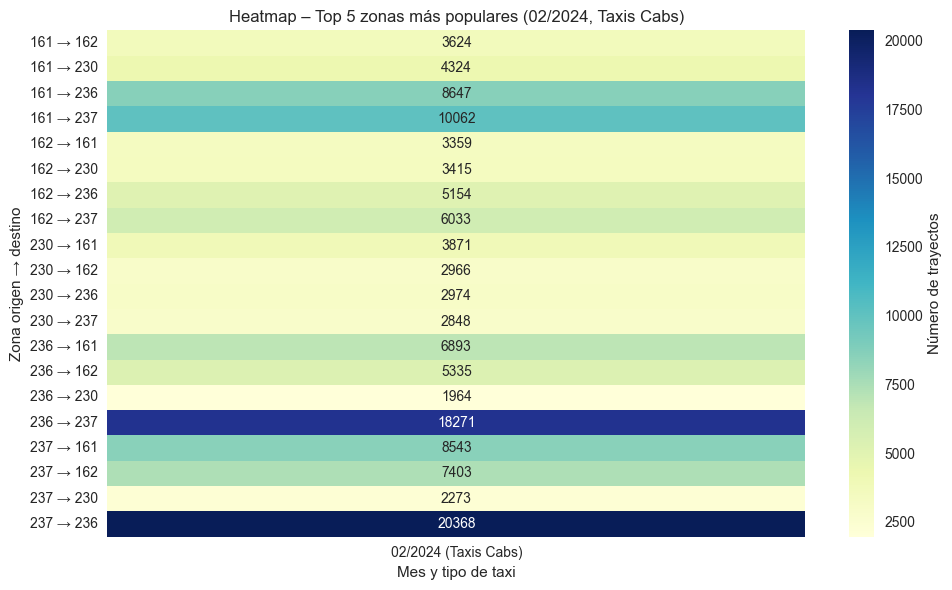

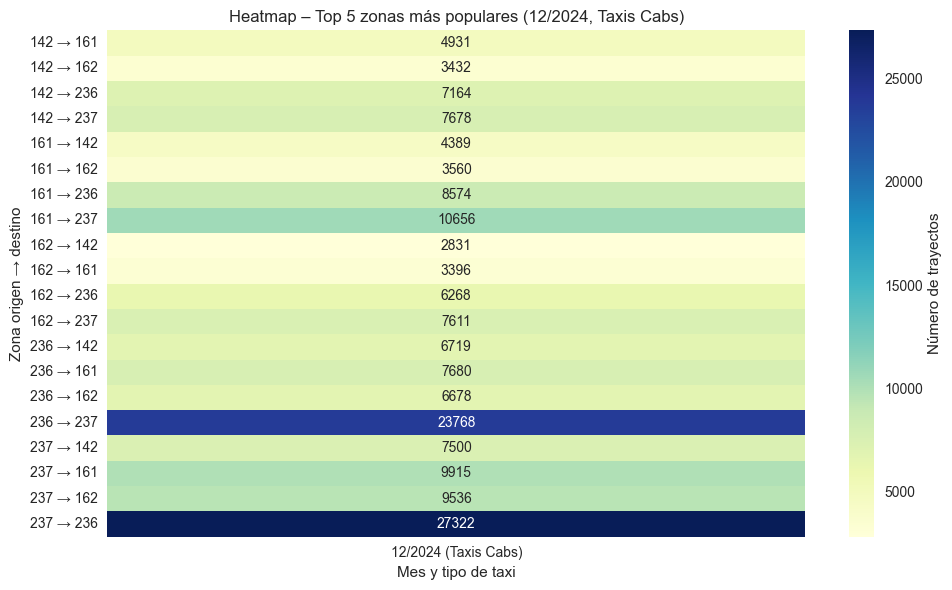

In [138]:
def plot_heatmap_top5_dict(datasets_dict, zona_nombres=None, decimals=3):
    """
    Genera un heatmap con trayectos entre las 5 zonas más populares para cada dataset del diccionario.

    Si no existen columnas de zonas, agrupa por coordenadas redondeadas (zonas sintéticas).

    Parámetros:
    - datasets_dict: diccionario {nombre_dataset: DataFrame}
    - zona_nombres: diccionario opcional para mapear LocationID a nombre de zona
    - decimals: decimales para redondear coordenadas en datasets antiguos
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    for key, df in datasets_dict.items():
        # Parsear tipo de taxi y fecha desde el nombre del archivo
        try:
            tipo, _, fecha = key.split("_")
            año, mes = fecha.split("-")
            mes_label = f"{mes}/{año}"
            nombre_dataset = tipo.capitalize() + " Cabs"
        except Exception as e:
            mes_label = key
            nombre_dataset = key

        # --- CASO 1: Dataset con zonas oficiales ---
        if all(col in df.columns for col in ["PULocationID", "DOLocationID"]):
            zonas = df.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')
            zonas_frecuentes = pd.concat([
                zonas.groupby('PULocationID')['count'].sum(),
                zonas.groupby('DOLocationID')['count'].sum()
            ]).groupby(level=0).sum().nlargest(5).index.tolist()

            zonas_top5 = zonas[
                zonas['PULocationID'].isin(zonas_frecuentes) &
                zonas['DOLocationID'].isin(zonas_frecuentes)
            ].copy()

            # Mapear a nombre de zona si se puede
            if zona_nombres:
                zonas_top5["Zona origen"] = zonas_top5["PULocationID"].map(zona_nombres)
                zonas_top5["Zona destino"] = zonas_top5["DOLocationID"].map(zona_nombres)
            else:
                zonas_top5["Zona origen"] = zonas_top5["PULocationID"].astype(str)
                zonas_top5["Zona destino"] = zonas_top5["DOLocationID"].astype(str)

        # --- CASO 2: Dataset con coordenadas (tipo 2009) ---
        elif all(c in df.columns for c in ["Start_Lon", "Start_Lat", "End_Lon", "End_Lat"]):
            # Redondear para crear "zonas sintéticas"
            df["PU_zone"] = list(zip(df["Start_Lon"].round(decimals), df["Start_Lat"].round(decimals)))
            df["DO_zone"] = list(zip(df["End_Lon"].round(decimals), df["End_Lat"].round(decimals)))
            zonas = df.groupby(['PU_zone', 'DO_zone']).size().reset_index(name='count')
            zonas_frecuentes = pd.concat([
                zonas.groupby('PU_zone')['count'].sum(),
                zonas.groupby('DO_zone')['count'].sum()
            ]).groupby(level=0).sum().nlargest(5).index.tolist()

            zonas_top5 = zonas[
                zonas['PU_zone'].isin(zonas_frecuentes) &
                zonas['DO_zone'].isin(zonas_frecuentes)
            ].copy()

            zonas_top5["Zona origen"] = zonas_top5["PU_zone"].astype(str)
            zonas_top5["Zona destino"] = zonas_top5["DO_zone"].astype(str)

        else:
            print(f"⚠️ {key}: no tiene ni columnas de zonas ni de coordenadas. Se omite.")
            continue

        zonas_top5["Zona"] = zonas_top5["Zona origen"] + " → " + zonas_top5["Zona destino"]
        zonas_top5["Mes-Tipo"] = f"{mes_label} ({nombre_dataset})"

        # Pivot para heatmap
        pivot_df = zonas_top5.pivot(index="Zona", columns="Mes-Tipo", values="count").fillna(0)

        # Dibujar heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Número de trayectos'})
        plt.title(f"Heatmap – Top 5 zonas más populares ({mes_label}, {nombre_dataset})")
        plt.ylabel("Zona origen → destino")
        plt.xlabel("Mes y tipo de taxi")
        plt.tight_layout()
        plt.show()


# Generamos heatmaps para los datasets Limpios
plot_heatmap_top5_dict(cleaned_datasets)

# Segunda Parte: Análisis Cualitativo

## 2.1	¿Cuál es el trayecto en el que la relación precio/km es más alta? ¿Cuál es el trayecto en el que la relación tiempo/km es más alta? ¿Cuál es el trayecto en el que la relación precio/tiempo es más alta?

### Identificador de Outliers

In [139]:
# Función para detectar outliers multivariables en datasets de taxis
def identificar_outliers_dict(datasets_dict):
    """
    Detecta outliers en múltiples variables clave de trayectos de taxi mediante el método IQR (Interquartile Range).

    Variables evaluadas:
    - trip_distance (distancia del viaje)
    - fare_amount (importe del trayecto)
    - trip_duration_min (duración estimada en minutos)
    - fare_per_km (importe por kilómetro recorrido)

    Se calcula un resumen para cada dataset y se muestra por pantalla:
    - Número de outliers por variable
    - Límites inferior y superior según IQR

    Retorna:
        dict con {nombre_dataset: DataFrame con filas outlier y columna adicional 'Outlier en'}
    """
    outliers_dict = {}

    for nombre, df in datasets_dict.items():
        df = df.copy()
        print(f"\n📊 Analizando dataset: {nombre}")

        # Asegurar columna de duración si no existe
        if "trip_duration_min" not in df.columns:
            pickup_cols = [c for c in ['tpep_pickup_datetime', 'lpep_pickup_datetime', 'pickup_datetime'] if c in df.columns]
            dropoff_cols = [c for c in ['tpep_dropoff_datetime', 'lpep_dropoff_datetime', 'dropoff_datetime', 'dropOff_datetime'] if c in df.columns]
            if pickup_cols and dropoff_cols:
                df["trip_duration_min"] = (
                    pd.to_datetime(df[dropoff_cols[0]], errors="coerce") -
                    pd.to_datetime(df[pickup_cols[0]], errors="coerce")
                ).dt.total_seconds() / 60

        # Calcular fare_per_km si no existe
        if 'fare_amount' in df.columns and 'trip_distance' in df.columns:
            df = df[df['trip_distance'] > 0].copy()
            df['fare_per_km'] = df['fare_amount'] / (df['trip_distance'] * 1.60934)  # ajuste a km

        # Selección de columnas relevantes
        columnas = ['trip_distance', 'fare_amount', 'trip_duration_min', 'fare_per_km']
        columnas = [col for col in columnas if col in df.columns]

        outlier_flags = pd.DataFrame(index=df.index)
        resumen = []

        # Aplicar método IQR a cada columna
        for col in columnas:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lim_inf = Q1 - 1.5 * IQR
            lim_sup = Q3 + 1.5 * IQR

            flag = (df[col] < lim_inf) | (df[col] > lim_sup)
            outlier_flags[col + '_outlier'] = flag
            resumen.append((col, flag.sum(), lim_inf, lim_sup))

        # Combinar todos los outliers
        outlier_rows = df[outlier_flags.any(axis=1)].copy()
        if not outlier_rows.empty:
            outlier_rows['Outlier en'] = outlier_flags[outlier_flags.any(axis=1)].apply(
                lambda x: ', '.join(x.index[x].str.replace('_outlier', '')), axis=1
            )
            outliers_dict[nombre] = outlier_rows

        # Mostrar resumen por pantalla con detalles
        print("  📌 Resumen de outliers detectados:")
        for col, count, low, high in resumen:
            print(f"    ▪ {col:<18}: {count:>5} outliers fuera de rango [{low:.2f}, {high:.2f}]")

        if not resumen:
            print("    ⚠️ No se encontraron columnas numéricas válidas para análisis.")

    print("\n✅ Análisis de outliers finalizado.")
    return outliers_dict

# Ejecutar la detección sobre los datasets limpios
detectados = identificar_outliers_dict(cleaned_datasets)


📊 Analizando dataset: taxis_tripdata_2024-02
  📌 Resumen de outliers detectados:
    ▪ trip_distance     : 353293 outliers fuera de rango [-2.16, 6.56]
    ▪ fare_amount       : 278706 outliers fuera de rango [-7.77, 37.75]
    ▪ trip_duration_min : 161670 outliers fuera de rango [-9.47, 37.12]
    ▪ fare_per_km       : 96268 outliers fuera de rango [0.64, 8.42]

📊 Analizando dataset: taxis_tripdata_2024-12
  📌 Resumen de outliers detectados:
    ▪ trip_distance     : 432866 outliers fuera de rango [-2.47, 7.05]
    ▪ fare_amount       : 279804 outliers fuera de rango [-11.75, 46.25]
    ▪ trip_duration_min : 192763 outliers fuera de rango [-13.37, 45.70]
    ▪ fare_per_km       : 164057 outliers fuera de rango [-0.04, 9.81]

✅ Análisis de outliers finalizado.


###  Muestra un resumen por DataSet de registros con incoherencias entre distancia y precio. 

In [140]:
def analizar_incoherencias_distancia_precio(datasets_dict, z_thresh=3.0, min_registros=100):
    """
    Analiza incoherencias entre trip_distance y fare_amount usando regresión lineal.
    No modifica los datasets. Solo informa.

    Parámetros:
    - datasets_dict: diccionario {nombre: DataFrame}
    - z_thresh: umbral de Z-score para considerar un registro incoherente
    - min_registros: mínimo de registros para aplicar regresión

    Muestra un resumen con el número de incoherencias detectadas por dataset.
    """
    resumen = []

    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Validar columnas necesarias
        if "trip_distance" not in df.columns or "fare_amount" not in df.columns:
            print(f"❌ {nombre}: columnas necesarias no encontradas. Se omite.")
            continue

        # Filtrar registros válidos
        df_validos = df[
            df["trip_distance"].notnull() &
            df["fare_amount"].notnull() &
            (df["trip_distance"] > 0) &
            (df["fare_amount"] > 0)
        ]

        if len(df_validos) < min_registros:
            print(f"⚠️ {nombre}: solo {len(df_validos)} registros válidos. Se omite.")
            continue

        # Regresión lineal
        X = df_validos[["trip_distance"]].values
        y = df_validos["fare_amount"].values
        modelo = LinearRegression()
        modelo.fit(X, y)

        # Calcular residuos y z-score
        y_pred = modelo.predict(X)
        residuos = y - y_pred
        z_residuos = zscore(residuos)

        # Identificar incoherencias
        incoherentes = (abs(z_residuos) > z_thresh).sum()
        total = len(df_validos)
        porcentaje = 100 * incoherentes / total

        resumen.append({
            "Dataset": nombre,
            "Registros válidos": total,
            "Incoherencias (> z_thresh)": incoherentes,
            "% Incoherente": f"{porcentaje:.2f}%"
        })

    # Mostrar resumen
    print("\n📊 Resumen de incoherencias entre distancia y precio (regresión):")
    display(pd.DataFrame(resumen))

# Ejemplo de uso
analizar_incoherencias_distancia_precio(cleaned_datasets, 3)



📊 Resumen de incoherencias entre distancia y precio (regresión):


,Dataset,Registros válidos,Incoherencias (> z_thresh),% Incoherente
0,taxis_tripdata_2024-02,2821949,43381,1.54%
1,taxis_tripdata_2024-12,3348657,55881,1.67%


### Trayecto con mayor precio por km

In [141]:
# Función para encontrar el trayecto con mayor precio por kilómetro
# incluyendo posibles causas del alto precio (recargos, hora punta, etc.)
def trayecto_mayor_precio_por_km(datasets_dict, zona_nombres=None, decimals=3):
    """
    Encuentra el trayecto con la mayor relación precio/km para cada dataset,
    mostrando información extendida:

    - Origen y destino (ID + nombre o coordenadas)
    - Duración del trayecto
    - Precio/km
    - Hora punta (Sí/No)
    - Día de la semana
    - Recargos presentes
    - Comparación precio registrado vs teórico

    Funciona con datasets de zonas (PULocationID/DOLocationID) o solo coordenadas (Start_Lon/Lat, End_Lon/Lat).
    """
    resumen = []
    global_max = None
    global_name = None

    for nombre, df in datasets_dict.items():
        df = df.copy()

        # --- CASO MODERNO: Zonas oficiales ---
        if all(col in df.columns for col in ["trip_distance", "fare_amount", "PULocationID", "DOLocationID", "pickup_datetime"]):
            # Asegura duración
            if "trip_duration_min" not in df.columns and "dropoff_datetime" in df.columns:
                df["trip_duration_min"] = (
                    pd.to_datetime(df["dropoff_datetime"], errors="coerce") -
                    pd.to_datetime(df["pickup_datetime"], errors="coerce")
                ).dt.total_seconds() / 60

            # Hora pico y día
            if "Hora_Pico" not in df.columns:
                df["Hora"] = pd.to_datetime(df["pickup_datetime"], errors="coerce").dt.hour
                df['Hora_Pico'] = df['Hora'].apply(lambda x: 1 if (7 <= x < 10) or (16 <= x < 19) else 0)
            if "Dia" not in df.columns:
                df["Dia"] = pd.to_datetime(df["pickup_datetime"], errors="coerce").dt.day_name()

            df = df[
                (df["trip_distance"] > 0) &
                (df["fare_amount"] > 0) &
                (df["trip_duration_min"] > 0) &
                (df["PULocationID"].notnull()) &
                (df["DOLocationID"].notnull())
            ].copy()

            if df.empty:
                print(f"⚠️ {nombre}: sin registros válidos para calcular precio/km.")
                continue

            tarifa_inicial = 3.00
            tarifa_milla = 2.50
            tarifa_minuto = 0.70
            df["precio_teorico_estimado"] = (
                tarifa_inicial +
                df["trip_distance"] * tarifa_milla +
                df["trip_duration_min"] * tarifa_minuto
            )
            df["precio_ratio"] = df["fare_amount"] / df["precio_teorico_estimado"]
            df["fare_per_km"] = df["fare_amount"] / (df["trip_distance"] * 1.60934)

            top = df.loc[df["fare_per_km"].idxmax()]

            hora_pico_str = "Sí" if int(top.get("Hora_Pico", 0)) == 1 else "No"
            weekday = top.get("Dia") if pd.notnull(top.get("Dia")) else None

            recargos = []
            if "mta_tax" in top and top["mta_tax"] > 0:
                recargos.append("MTA")
            if "tolls_amount" in top and top["tolls_amount"] > 0:
                recargos.append("Peaje")
            if "congestion_surcharge" in top and top["congestion_surcharge"] > 0:
                recargos.append("Congestión")
            if "airport_fee" in top and top["airport_fee"] > 0:
                recargos.append("Aeropuerto")
            if "night_surcharge" in top and top["night_surcharge"] > 0:
                recargos.append("Noche")
            if "extra" in top and top["extra"] > 0:
                recargos.append("Extra")

            origen = int(top["PULocationID"])
            destino = int(top["DOLocationID"])
            origen_str = f"{origen} - {zona_nombres.get(origen, 'Desconocido') if zona_nombres else origen}"
            destino_str = f"{destino} - {zona_nombres.get(destino, 'Desconocido') if zona_nombres else destino}"

        # --- CASO ANTIGUO: Coordenadas (tipo 2009) ---
        elif all(c in df.columns for c in ["trip_distance", "fare_amount", "Start_Lon", "Start_Lat", "End_Lon", "End_Lat", "pickup_datetime"]):
            # Asegura duración
            if "trip_duration_min" not in df.columns and "dropoff_datetime" in df.columns:
                df["trip_duration_min"] = (
                    pd.to_datetime(df["dropoff_datetime"], errors="coerce") -
                    pd.to_datetime(df["pickup_datetime"], errors="coerce")
                ).dt.total_seconds() / 60

            # Hora pico y día
            if "Hora_Pico" not in df.columns:
                df["Hora"] = pd.to_datetime(df["pickup_datetime"], errors="coerce").dt.hour
                df['Hora_Pico'] = df['Hora'].apply(lambda x: 1 if (7 <= x < 10) or (16 <= x < 19) else 0)
            if "Dia" not in df.columns:
                df["Dia"] = pd.to_datetime(df["pickup_datetime"], errors="coerce").dt.day_name()

            df = df[
                (df["trip_distance"] > 0) &
                (df["fare_amount"] > 0) &
                (df["trip_duration_min"] > 0) &
                (df["Start_Lon"].notnull()) & (df["Start_Lat"].notnull()) &
                (df["End_Lon"].notnull()) & (df["End_Lat"].notnull())
            ].copy()

            if df.empty:
                print(f"⚠️ {nombre}: sin registros válidos para calcular precio/km.")
                continue

            tarifa_inicial = 3.00
            tarifa_milla = 2.50
            tarifa_minuto = 0.70
            df["precio_teorico_estimado"] = (
                tarifa_inicial +
                df["trip_distance"] * tarifa_milla +
                df["trip_duration_min"] * tarifa_minuto
            )
            df["precio_ratio"] = df["fare_amount"] / df["precio_teorico_estimado"]
            df["fare_per_km"] = df["fare_amount"] / (df["trip_distance"] * 1.60934)

            # Zonas sintéticas: redondeo de coordenadas
            df["PU_zone"] = list(zip(df["Start_Lon"].round(decimals), df["Start_Lat"].round(decimals)))
            df["DO_zone"] = list(zip(df["End_Lon"].round(decimals), df["End_Lat"].round(decimals)))
            top = df.loc[df["fare_per_km"].idxmax()]

            hora_pico_str = "Sí" if int(top.get("Hora_Pico", 0)) == 1 else "No"
            weekday = top.get("Dia") if pd.notnull(top.get("Dia")) else None

            recargos = []
            if "mta_tax" in top and top["mta_tax"] > 0:
                recargos.append("MTA")
            if "tolls" in top and top["tolls"] > 0:
                recargos.append("Peaje")
            if "extra" in top and top["extra"] > 0:
                recargos.append("Extra")
            # Otros recargos: (puedes agregar más campos según tu dataset 2009...)

            origen_str = f"{top['PU_zone']}"
            destino_str = f"{top['DO_zone']}"

        else:
            print(f"⚠️ {nombre}: columnas requeridas no encontradas. Se omite.")
            continue

        resumen.append({
            "Dataset": nombre,
            "Origen": origen_str,
            "Destino": destino_str,
            "Distancia (mi)": top["trip_distance"],
            "Precio ($)": top["fare_amount"],
            "Precio/km ($)": top["fare_per_km"],
            "Duración (min)": top["trip_duration_min"],
            "Hora Punta": hora_pico_str,
            "Día": weekday,
            "Recargos": ", ".join(recargos) if recargos else "Ninguno",
            "Precio Teórico ($)": top["precio_teorico_estimado"],
            "Ratio Real/Teórico": top["precio_ratio"]
        })

        if global_max is None or top["fare_per_km"] > global_max["fare_per_km"]:
            global_max = top
            global_name = nombre

    if global_max is not None:
        # Determina origen/destino según si es moderno o antiguo (ya comprobado)
        if "PULocationID" in global_max:
            origen = int(global_max["PULocationID"])
            destino = int(global_max["DOLocationID"])
            origen_str = f"{origen} - {zona_nombres.get(origen, 'Desconocido') if zona_nombres else origen}"
            destino_str = f"{destino} - {zona_nombres.get(destino, 'Desconocido') if zona_nombres else destino}"
        else:
            origen_str = f"{global_max['PU_zone']}"
            destino_str = f"{global_max['DO_zone']}"

        hora_pico_str = "Sí" if int(global_max.get("Hora_Pico", 0)) == 1 else "No"
        weekday = global_max.get("Dia") if pd.notnull(global_max.get("Dia")) else None

        recargos = []
        for campo in ["mta_tax", "tolls_amount", "tolls", "congestion_surcharge", "airport_fee", "night_surcharge", "extra"]:
            if campo in global_max and global_max[campo] > 0:
                recargos.append(campo.replace("_", " ").capitalize())

        resumen.append({
            "Dataset": f"GLOBAL ({global_name})",
            "Origen": origen_str,
            "Destino": destino_str,
            "Distancia (mi)": global_max["trip_distance"],
            "Precio ($)": global_max["fare_amount"],
            "Precio/km ($)": global_max["fare_per_km"],
            "Duración (min)": global_max["trip_duration_min"],
            "Hora Punta": hora_pico_str,
            "Día": weekday,
            "Recargos": ", ".join(recargos) if recargos else "Ninguno",
            "Precio Teórico ($)": global_max["precio_teorico_estimado"],
            "Ratio Real/Teórico": global_max["precio_ratio"]
        })

    return pd.DataFrame(resumen)

# Ejecutar
print("\n📊 Trayecto con mayor precio/km:")
trayecto_mayor_precio_por_km(cleaned_datasets, zona_nombres)



📊 Trayecto con mayor precio/km:


,Dataset,Origen,Destino,Distancia (mi),Precio ($),Precio/km ($),Duración (min),Hora Punta,Día,Recargos,Precio Teórico ($),Ratio Real/Teórico
0,taxis_tripdata_2024-02,164 - Midtown South,137 - Kips Bay,0.33,23.95,45.096597,10.000000,No,Sunday,MTA,10.825000,2.212471
1,taxis_tripdata_2024-12,163 - Midtown North,161 - Midtown Center,0.49,38.87,49.291343,15.316667,Sí,Thursday,MTA,14.946667,2.600580
2,GLOBAL (taxis_tripdata_2024-12),163 - Midtown North,161 - Midtown Center,0.49,38.87,49.291343,15.316667,Sí,Thursday,Mta tax,14.946667,2.600580


### Trayecto con la relación tiempo/km más alta

In [142]:

# Función para encontrar el trayecto con mayor duración por kilómetro
# incluyendo posibles causas del alto tiempo (tráfico, hora punta, etc.)
def trayecto_mayor_duracion_por_km(datasets_dict, zona_nombres=None, decimals=3):
    """
    Encuentra el trayecto con mayor duración por kilómetro para cada dataset,
    y también a nivel global, mostrando nombre de zona o coordenadas y si es hora punta.

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}
        zona_nombres: diccionario {zone_id: nombre_zona} (opcional)
        decimals: decimales para agrupar coordenadas en caso de dataset antiguo

    Retorna:
        DataFrame resumen con los trayectos más lentos (min/km), indicando hora punta ("Sí"/"No")
    """
    resumen = []
    global_max = None
    global_name = None
    global_origen_str = None
    global_destino_str = None

    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Detectar columnas de datetime
        pickup_cols = [col for col in df.columns if 'pickup' in col and 'datetime' in col]
        dropoff_cols = [col for col in df.columns if 'drop' in col and 'datetime' in col]

        if not pickup_cols or not dropoff_cols:
            print(f"⚠️ {nombre}: columnas de datetime no encontradas. Se omite.")
            continue

        pickup = pd.to_datetime(df[pickup_cols[0]], errors='coerce')
        dropoff = pd.to_datetime(df[dropoff_cols[0]], errors='coerce')
        df["duration_min"] = (dropoff - pickup).dt.total_seconds() / 60

        if "trip_distance" not in df.columns:
            print(f"⚠️ {nombre}: columna 'trip_distance' no encontrada. Se omite.")
            continue

        df = df[(df["trip_distance"] > 0) & (df["duration_min"] > 0)].copy()

        if df.empty:
            print(f"⚠️ {nombre}: sin registros válidos tras filtrado. Se omite.")
            continue

        df["min_per_km"] = df["duration_min"] / df["trip_distance"]

        # Clasificación de hora punta (7-10h o 16-19h)
        if "Hora_Pico" not in df.columns:
            df["Hora"] = pickup.dt.hour
            df['Hora_Pico'] = df['Hora'].apply(lambda x: 1 if (7 <= x < 10) or (16 <= x < 19) else 0)

        # --- Zonas oficiales (modernos) ---
        if "PULocationID" in df.columns and "DOLocationID" in df.columns:
            top = df.loc[df["min_per_km"].idxmax()]
            origen_id = int(top["PULocationID"])
            destino_id = int(top["DOLocationID"])
            origen_str = f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido') if zona_nombres else origen_id}"
            destino_str = f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido') if zona_nombres else destino_id}"
        # --- Coordenadas (2009) ---
        elif all(c in df.columns for c in ["Start_Lon", "Start_Lat", "End_Lon", "End_Lat"]):
            # Zonas sintéticas: coordenadas redondeadas
            df["PU_zone"] = list(zip(df["Start_Lon"].round(decimals), df["Start_Lat"].round(decimals)))
            df["DO_zone"] = list(zip(df["End_Lon"].round(decimals), df["End_Lat"].round(decimals)))
            top = df.loc[df["min_per_km"].idxmax()]
            origen_str = str(top["PU_zone"])
            destino_str = str(top["DO_zone"])
        else:
            print(f"⚠️ {nombre}: no se detectan columnas de zonas ni coordenadas para origen/destino.")
            continue

        hora_pico_str = "Sí" if int(top.get("Hora_Pico", 0)) == 1 else "No"

        resumen.append({
            "Dataset": nombre,
            "Origen": origen_str,
            "Destino": destino_str,
            "Distancia (mi)": top["trip_distance"],
            "Duración (min)": top["duration_min"],
            "Min/km": top["min_per_km"],
            "Hora Punta": hora_pico_str
        })

        # Guardar para el global
        if global_max is None or top["min_per_km"] > global_max["min_per_km"]:
            global_max = top
            global_name = nombre
            global_origen_str = origen_str
            global_destino_str = destino_str

    if global_max is not None:
        hora_pico_str = "Sí" if int(global_max.get("Hora_Pico", 0)) == 1 else "No"
        resumen.append({
            "Dataset": f"GLOBAL ({global_name})",
            "Origen": global_origen_str,
            "Destino": global_destino_str,
            "Distancia (mi)": global_max["trip_distance"],
            "Duración (min)": global_max["duration_min"],
            "Min/km": global_max["min_per_km"],
            "Hora Punta": hora_pico_str
        })

    return pd.DataFrame(resumen)

# Ejecutar la función para encontrar el trayecto con mayor duración por kilómetro
print("\n📊 Trayecto con la relación tiempo/km más alta:")
trayecto_mayor_duracion_por_km(cleaned_datasets, zona_nombres)


📊 Trayecto con la relación tiempo/km más alta:


,Dataset,Origen,Destino,Distancia (mi),Duración (min),Min/km,Hora Punta
0,taxis_tripdata_2024-02,144 - Little Italy/NoLiTa,125 - Hudson Sq,0.58,18.666667,32.183908,Sí
1,taxis_tripdata_2024-12,170 - Murray Hill,186 - Penn Station/Madison Sq West,0.93,29.933333,32.186380,No
2,GLOBAL (taxis_tripdata_2024-12),170 - Murray Hill,186 - Penn Station/Madison Sq West,0.93,29.933333,32.186380,No


### Trayecto con relación precio/tiempo más alta

In [143]:
def trayecto_mayor_precio_por_minuto(datasets_dict, zona_nombres=None, decimals=3):
    """
    Encuentra el trayecto con la mayor relación precio por minuto para cada dataset y a nivel global,
    mostrando orígenes y destinos por zona o coordenadas.

    Devuelve:
        DataFrame resumen por dataset y global, mostrando outliers solo si han pasado la limpieza.
    """
    resumen = []
    global_max = None
    global_name = None

    for nombre, df in datasets_dict.items():
        df = df.copy()
        # Usar la columna ya ajustada por tarifa mínima y limpieza: 'Precio ($)'
        if "Precio ($)" not in df.columns or "trip_duration_min" not in df.columns:
            print(f"⚠️ {nombre}: faltan columnas necesarias. Se omite.")
            continue

        df = df[(df["trip_duration_min"] > 0) & (df["Precio ($)"] > 0)].copy()

        # Calcula $/min si no existe, para asegurar robustez
        if "$/min" not in df.columns:
            df["$/min"] = df["Precio ($)"] / df["trip_duration_min"]

        # Filtra por el criterio de limpieza final, por si acaso algún registro suelto lo pasó
        df = df[df["$/min"] <= 5]

        if df.empty:
            print(f"⚠️ {nombre}: sin registros válidos para calcular $/min.")
            continue

        # Zonas modernas (PULocationID/DOLocationID)
        if "PULocationID" in df.columns and "DOLocationID" in df.columns:
            top = df.loc[df["$/min"].idxmax()]
            origen_str = f"{int(top['PULocationID'])} - {zona_nombres.get(int(top['PULocationID']), 'Desconocido') if zona_nombres else int(top['PULocationID'])}"
            destino_str = f"{int(top['DOLocationID'])} - {zona_nombres.get(int(top['DOLocationID']), 'Desconocido') if zona_nombres else int(top['DOLocationID'])}"
        # Coordenadas antiguas
        elif all(col in df.columns for col in ["Start_Lon", "Start_Lat", "End_Lon", "End_Lat"]):
            # Zonas sintéticas: coordenadas redondeadas
            df["PU_zone"] = list(zip(df["Start_Lon"].round(decimals), df["Start_Lat"].round(decimals)))
            df["DO_zone"] = list(zip(df["End_Lon"].round(decimals), df["End_Lat"].round(decimals)))
            top = df.loc[df["$/min"].idxmax()]
            origen_str = str(top["PU_zone"])
            destino_str = str(top["DO_zone"])
        else:
            print(f"⚠️ {nombre}: columnas de zona ni coordenadas detectadas. Se omite.")
            continue

        resumen.append({
            "Dataset": nombre,
            "Origen": origen_str,
            "Destino": destino_str,
            "Duración (min)": top["trip_duration_min"],
            "Precio ($)": top["Precio ($)"],
            "$/min": top["$/min"]
        })

        if global_max is None or top["$/min"] > global_max["$/min"]:
            global_max = top
            global_name = nombre
            global_origen_str = origen_str
            global_destino_str = destino_str

    if global_max is not None:
        resumen.append({
            "Dataset": f"GLOBAL ({global_name})",
            "Origen": global_origen_str,
            "Destino": global_destino_str,
            "Duración (min)": global_max["trip_duration_min"],
            "Precio ($)": global_max["Precio ($)"],
            "$/min": global_max["$/min"]
        })

    return pd.DataFrame(resumen)

# Ejecutar la función para encontrar el trayecto con mayor precio por minuto
print("\n📊 Trayecto con la relación precio/minuto más alta:")
trayecto_mayor_precio_por_minuto(cleaned_datasets, zona_nombres)



📊 Trayecto con la relación precio/minuto más alta:


,Dataset,Origen,Destino,Duración (min),Precio ($),$/min
0,taxis_tripdata_2024-02,162 - Midtown East,161 - Midtown Center,1.4,7.0,5.0
1,taxis_tripdata_2024-12,48 - Clinton East,230 - Times Sq/Theatre District,2.6,13.0,5.0
2,GLOBAL (taxis_tripdata_2024-02),162 - Midtown East,161 - Midtown Center,1.4,7.0,5.0


## 2.2	¿Cuál es el trayecto en el que la relación precio/km es más baja? 

In [144]:
def trayecto_menor_precio_por_km(
    datasets_dict,
    zona_nombres=None,
    min_distance=0.1,
    min_price_per_km=0.2,
    min_price_total=2.0,
    decimals=3
):
    """
    Versión optimizada en memoria:
    Busca el trayecto con menor precio/km para cada dataset, soportando zonas y coordenadas.
    Solo almacena los valores relevantes y nunca el DataFrame completo.
    """
    import gc  # Garbage collector

    resultados = []
    global_min_value = None
    global_min_row = None
    global_min_dataset = None
    global_min_origen_str = None
    global_min_destino_str = None

    for nombre, df in datasets_dict.items():
        # Elimina columnas no usadas en el análisis para ahorrar memoria
        cols_to_keep = set([
            "trip_distance", "Precio ($)",
            "PULocationID", "DOLocationID",
            "Start_Lon", "Start_Lat", "End_Lon", "End_Lat"
        ])
        df_cols = set(df.columns)
        cols_to_drop = list(df_cols - cols_to_keep)
        if cols_to_drop:
            df = df.drop(columns=cols_to_drop)

        # Zonas modernas
        if all(col in df.columns for col in ["trip_distance", "Precio ($)", "PULocationID", "DOLocationID"]):
            # Filtrado vectorizado y cálculos en bloque
            mask = (
                (df["trip_distance"] >= min_distance) &
                (df["Precio ($)"] >= min_price_total)
            )
            temp_df = df.loc[mask, ["trip_distance", "Precio ($)", "PULocationID", "DOLocationID"]]
            if temp_df.empty:
                del df, temp_df; gc.collect()
                continue

            precio_km = temp_df["Precio ($)"] / (temp_df["trip_distance"] * 1.60934)
            temp_df = temp_df.assign(**{"Precio/km ($)": precio_km.values})
            temp_df = temp_df[temp_df["Precio/km ($)"] >= min_price_per_km]

            if temp_df.empty:
                del df, temp_df; gc.collect()
                continue

            idx_min = temp_df["Precio/km ($)"].idxmin()
            row = temp_df.loc[idx_min]
            origen_str = f"{int(row['PULocationID'])} - {zona_nombres.get(int(row['PULocationID']), 'Desconocido') if zona_nombres else int(row['PULocationID'])}"
            destino_str = f"{int(row['DOLocationID'])} - {zona_nombres.get(int(row['DOLocationID']), 'Desconocido') if zona_nombres else int(row['DOLocationID'])}"

        # Dataset antiguo por coordenadas
        elif all(col in df.columns for col in ["trip_distance", "Precio ($)", "Start_Lon", "Start_Lat", "End_Lon", "End_Lat"]):
            mask = (
                (df["trip_distance"] >= min_distance) &
                (df["Precio ($)"] >= min_price_total)
            )
            temp_df = df.loc[mask, ["trip_distance", "Precio ($)", "Start_Lon", "Start_Lat", "End_Lon", "End_Lat"]]
            if temp_df.empty:
                del df, temp_df; gc.collect()
                continue

            precio_km = temp_df["Precio ($)"] / (temp_df["trip_distance"] * 1.60934)
            temp_df = temp_df.assign(**{"Precio/km ($)": precio_km.values})
            temp_df = temp_df[temp_df["Precio/km ($)"] >= min_price_per_km]
            if temp_df.empty:
                del df, temp_df; gc.collect()
                continue

            temp_df["PU_zone"] = list(zip(temp_df["Start_Lon"].round(decimals), temp_df["Start_Lat"].round(decimals)))
            temp_df["DO_zone"] = list(zip(temp_df["End_Lon"].round(decimals), temp_df["End_Lat"].round(decimals)))

            idx_min = temp_df["Precio/km ($)"].idxmin()
            row = temp_df.loc[idx_min]
            origen_str = str(row["PU_zone"])
            destino_str = str(row["DO_zone"])

        else:
            print(f"⚠️ {nombre}: columnas necesarias no encontradas. Se omite.")
            del df; gc.collect()
            continue

        resultados.append({
            "Dataset": nombre,
            "Origen": origen_str,
            "Destino": destino_str,
            "Distancia (mi)": row["trip_distance"],
            "Precio ($)": row["Precio ($)"],
            "Precio/km ($)": row["Precio/km ($)"]
        })

        if (global_min_value is None) or (row["Precio/km ($)"] < global_min_value):
            global_min_value = row["Precio/km ($)"]
            global_min_row = row
            global_min_dataset = nombre
            global_min_origen_str = origen_str
            global_min_destino_str = destino_str

        # Borra variables temporales tras cada dataset
        del df, temp_df, precio_km
        gc.collect()

    if global_min_row is not None:
        resultados.append({
            "Dataset": f"GLOBAL ({global_min_dataset})",
            "Origen": global_min_origen_str,
            "Destino": global_min_destino_str,
            "Distancia (mi)": global_min_row["trip_distance"],
            "Precio ($)": global_min_row["Precio ($)"],
            "Precio/km ($)": global_min_row["Precio/km ($)"]
        })

    import pandas as pd
    return pd.DataFrame(resultados)

# Ejecutar la función para encontrar el trayecto con menor precio/km
print("\n📊 Trayecto con la relación precio/km más baja:")
trayecto_menor_precio_por_km(cleaned_datasets, zona_nombres, min_distance=0.1)


📊 Trayecto con la relación precio/km más baja:


,Dataset,Origen,Destino,Distancia (mi),Precio ($),Precio/km ($)
0,taxis_tripdata_2024-02,132 - JFK Airport,265 - Outside of NYC,16.805,18.85,0.696988
1,taxis_tripdata_2024-12,62 - Crown Heights South,17 - Bedford,17.900,19.00,0.659558
2,GLOBAL (taxis_tripdata_2024-12),62 - Crown Heights South,17 - Bedford,17.900,19.00,0.659558


### ¿Cuál es el trayecto en el que la relación tiempo/km es más baja? 

In [145]:
def trayecto_menor_tiempo_por_km(datasets_dict, zona_nombres=None, decimals=3):
    """
    Encuentra el trayecto con menor relación tiempo/km (minutos por milla) para cada dataset,
    así como el trayecto global, **optimizado para memoria** y compatible con datasets 2009.
    """
    import pandas as pd

    resultados = []
    global_min = None
    global_name = None
    global_info = None

    for nombre, df in datasets_dict.items():
        # SOLO selecciona columnas imprescindibles y evita copiar innecesariamente
        columnas_esenciales = [
            "trip_distance", "trip_duration_min",
            "PULocationID", "DOLocationID",
            "Start_Lon", "Start_Lat", "End_Lon", "End_Lat"
        ]
        cols = [col for col in columnas_esenciales if col in df.columns]

        # Procesa en memoria solo lo justo
        # Filtro previo de filas válidas (no copies el df entero)
        mask_dist = df["trip_distance"] > 0 if "trip_distance" in df.columns else pd.Series(False)
        # Si falta duration, la calculas al vuelo solo para las filas válidas
        if "trip_duration_min" not in df.columns:
            pickup_cols = [c for c in df.columns if "pickup" in c and "datetime" in c]
            dropoff_cols = [c for c in df.columns if "drop" in c and "datetime" in c]
            if pickup_cols and dropoff_cols:
                pickup = pd.to_datetime(df.loc[mask_dist, pickup_cols[0]], errors='coerce')
                dropoff = pd.to_datetime(df.loc[mask_dist, dropoff_cols[0]], errors='coerce')
                duration_min = (dropoff - pickup).dt.total_seconds() / 60
            else:
                print(f"⚠️ {nombre}: sin columnas de fecha válidas. Se omite.")
                continue
        else:
            duration_min = df.loc[mask_dist, "trip_duration_min"]

        # Filtro por duración válida
        mask_valid = (duration_min > 0)
        idx_valid = duration_min[mask_valid].index

        if idx_valid.empty:
            continue

        # Solo selecciona lo necesario en esas filas
        df_valid = df.loc[idx_valid, cols].copy()
        df_valid = df_valid.assign(trip_duration_min=duration_min.loc[idx_valid])

        # Calcula la métrica SOLO en las filas válidas
        min_per_km = df_valid["trip_duration_min"] / df_valid["trip_distance"]
        idx_min = min_per_km.idxmin()
        row = df_valid.loc[idx_min]

        # Zonas modernas
        if "PULocationID" in row and "DOLocationID" in row:
            origen_str = f"{int(row['PULocationID'])} - {zona_nombres.get(int(row['PULocationID']), 'Desconocido') if zona_nombres else int(row['PULocationID'])}"
            destino_str = f"{int(row['DOLocationID'])} - {zona_nombres.get(int(row['DOLocationID']), 'Desconocido') if zona_nombres else int(row['DOLocationID'])}"
        # Dataset 2009
        elif all(c in row for c in ["Start_Lon", "Start_Lat", "End_Lon", "End_Lat"]):
            origen_str = f"({round(row['Start_Lon'],decimals)}, {round(row['Start_Lat'],decimals)})"
            destino_str = f"({round(row['End_Lon'],decimals)}, {round(row['End_Lat'],decimals)})"
        else:
            print(f"⚠️ {nombre}: no hay columnas de zona ni coordenadas para identificar origen/destino.")
            continue

        resultados.append({
            "Dataset": nombre,
            "Origen": origen_str,
            "Destino": destino_str,
            "Distancia (mi)": row["trip_distance"],
            "Duración (min)": row["trip_duration_min"],
            "Min/km": min_per_km.loc[idx_min]
        })

        if (global_min is None) or (min_per_km.loc[idx_min] < global_min):
            global_min = min_per_km.loc[idx_min]
            global_name = nombre
            global_info = {
                "Origen": origen_str,
                "Destino": destino_str,
                "Distancia (mi)": row["trip_distance"],
                "Duración (min)": row["trip_duration_min"],
                "Min/km": min_per_km.loc[idx_min]
            }

        # Libera memoria
        del df_valid, min_per_km

    if global_min is not None:
        resultados.append({
            "Dataset": f"GLOBAL ({global_name})",
            **global_info
        })

    return pd.DataFrame(resultados)


# Ejecutar la función para encontrar el trayecto con menor tiempo/km
trayecto_menor_tiempo_por_km(cleaned_datasets)

,Dataset,Origen,Destino,Distancia (mi),Duración (min),Min/km
0,taxis_tripdata_2024-02,132 - 132,265 - 265,38.4,37.25,0.970052
1,taxis_tripdata_2024-12,140 - 140,182 - 182,31.1,30.10,0.967846
2,GLOBAL (taxis_tripdata_2024-12),140 - 140,182 - 182,31.1,30.10,0.967846


### ¿Cuál es el trayecto en el que la relación precio/tiempo es más baja?

In [146]:
def trayecto_menor_precio_por_minuto(datasets_dict, zona_nombres=None, min_duracion=0.5, min_precio_total=2.0, decimals=3):
    """
    Encuentra el trayecto con menor relación precio/tiempo (USD por minuto) para cada dataset,
    y el trayecto global con la menor relación.
    Soporta tanto datasets modernos (PULocationID) como antiguos (coordenadas).
    Usa siempre la columna 'Precio ($)' tras limpieza.

    Parámetros:
        datasets_dict: diccionario {nombre: DataFrame}
        zona_nombres: diccionario {zone_id: nombre_zona} (opcional)
        min_duracion: duración mínima para evitar divisiones por cero (min)
        min_precio_total: precio mínimo total permitido para evitar outliers (USD)
        decimals: decimales en coordenadas

    Retorna:
        DataFrame con los trayectos más baratos por minuto, ya filtrados.
    """
    import pandas as pd

    resultados = []
    global_min = None
    global_name = None
    global_row = None

    for nombre, df in datasets_dict.items():
        df = df.copy()
        
        # Verifica que existen columnas mínimas para uno u otro formato
        if "Precio ($)" not in df.columns or "trip_duration_min" not in df.columns:
            print(f"⚠️ {nombre}: faltan columnas esenciales 'Precio ($)' o 'trip_duration_min'. Se omite.")
            continue

        # Filtro mínimo: duración y precio
        df = df[(df["trip_duration_min"] >= min_duracion) & (df["Precio ($)"] >= min_precio_total)].copy()
        if df.empty:
            continue

        # Calcula el precio por minuto
        df["Precio/min ($)"] = df["Precio ($)"] / df["trip_duration_min"]

        # Selecciona el trayecto con menor precio/min válido
        idx_min = df["Precio/min ($)"].idxmin()
        row = df.loc[idx_min]

        # Decide cómo representar origen/destino
        if all(c in row for c in ["PULocationID", "DOLocationID"]):
            origen = f"{int(row['PULocationID'])} - {zona_nombres.get(int(row['PULocationID']), 'Desconocido') if zona_nombres else int(row['PULocationID'])}"
            destino = f"{int(row['DOLocationID'])} - {zona_nombres.get(int(row['DOLocationID']), 'Desconocido') if zona_nombres else int(row['DOLocationID'])}"
        elif all(c in row for c in ["Start_Lon", "Start_Lat", "End_Lon", "End_Lat"]):
            origen = f"({round(row['Start_Lon'],decimals)}, {round(row['Start_Lat'],decimals)})"
            destino = f"({round(row['End_Lon'],decimals)}, {round(row['End_Lat'],decimals)})"
        else:
            print(f"⚠️ {nombre}: sin columnas de zona ni coordenadas, no se puede identificar origen/destino.")
            continue

        resultado = {
            "Dataset": nombre,
            "Origen": origen,
            "Destino": destino,
            "Duración (min)": row["trip_duration_min"],
            "Precio ($)": row["Precio ($)"],
            "Precio/min ($)": row["Precio/min ($)"]
        }
        resultados.append(resultado)

        if (global_min is None) or (row["Precio/min ($)"] < global_min):
            global_min = row["Precio/min ($)"]
            global_name = nombre
            global_row = resultado.copy()
            global_row["Dataset"] = f"GLOBAL ({global_name})"

    if global_row is not None:
        resultados.append(global_row)

    return pd.DataFrame(resultados)


# Ejecutar la función para encontrar el trayecto con menor precio/min
print("\n📊 Trayecto con la relación precio/minuto más baja:")
trayecto_menor_precio_por_minuto(cleaned_datasets, zona_nombres)



📊 Trayecto con la relación precio/minuto más baja:


,Dataset,Origen,Destino,Duración (min),Precio ($),Precio/min ($)
0,taxis_tripdata_2024-02,76 - East New York,225 - Stuyvesant Heights,92.716667,23.0,0.248068
1,taxis_tripdata_2024-12,263 - Yorkville West,75 - East Harlem South,96.350000,23.8,0.247016
2,GLOBAL (taxis_tripdata_2024-12),263 - Yorkville West,75 - East Harlem South,96.350000,23.8,0.247016


## 2.3	Muestra la evolución del tiempo medio de trayecto a lo largo del día. 

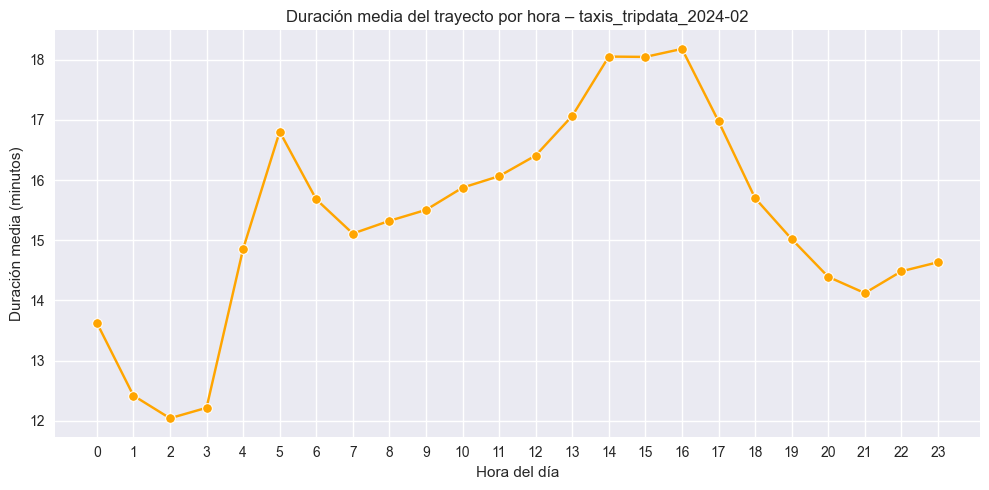

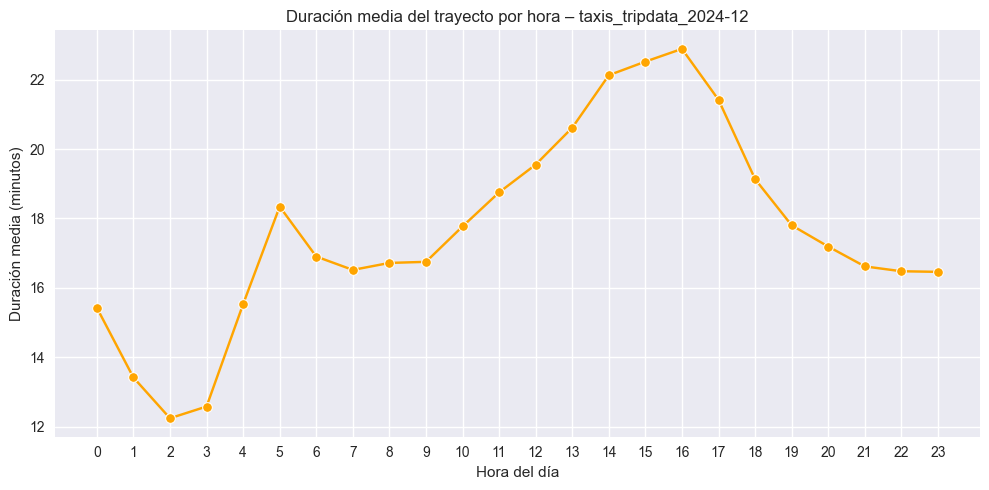

In [147]:
def plot_tiempo_medio_por_hora_dict(datasets_dict):
    """
    Grafica la duración media (en minutos) del trayecto a lo largo del día para cada dataset del diccionario.

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}
    """
    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Verificar columnas necesarias
        if 'pickup_datetime' in df.columns and 'dropoff_datetime' in df.columns:
            df['hora'] = pd.to_datetime(df['pickup_datetime'], errors='coerce').dt.hour
            df['duracion_min'] = (
                pd.to_datetime(df['dropoff_datetime'], errors='coerce') -
                pd.to_datetime(df['pickup_datetime'], errors='coerce')
            ).dt.total_seconds() / 60
        else:
            print(f"❌ {nombre}: columnas de fecha no encontradas. Se omite.")
            continue

        df = df[df['duracion_min'] > 0]
        if df.empty:
            print(f"⚠️ {nombre}: sin datos válidos para calcular duración.")
            continue

        media_por_hora = df.groupby('hora')['duracion_min'].mean()

        # Plot
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=media_por_hora.index, y=media_por_hora.values, marker="o", color="orange")
        plt.title(f"Duración media del trayecto por hora – {nombre}")
        plt.xlabel("Hora del día")
        plt.ylabel("Duración media (minutos)")
        plt.xticks(range(0, 24))
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Generar gráficos de duración media por hora para los datasets limpios
plot_tiempo_medio_por_hora_dict(cleaned_datasets)

### Muestra la evolución de la distancia media de trayecto a lo largo del día.

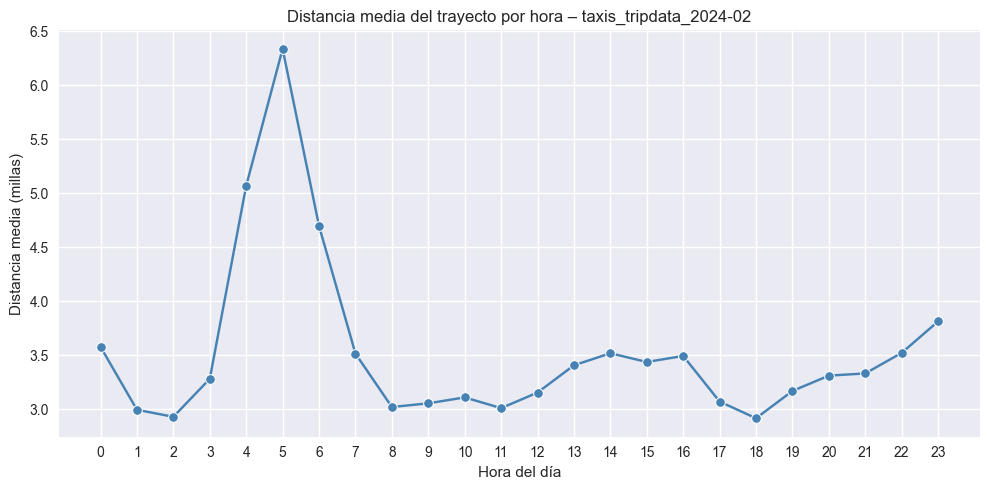

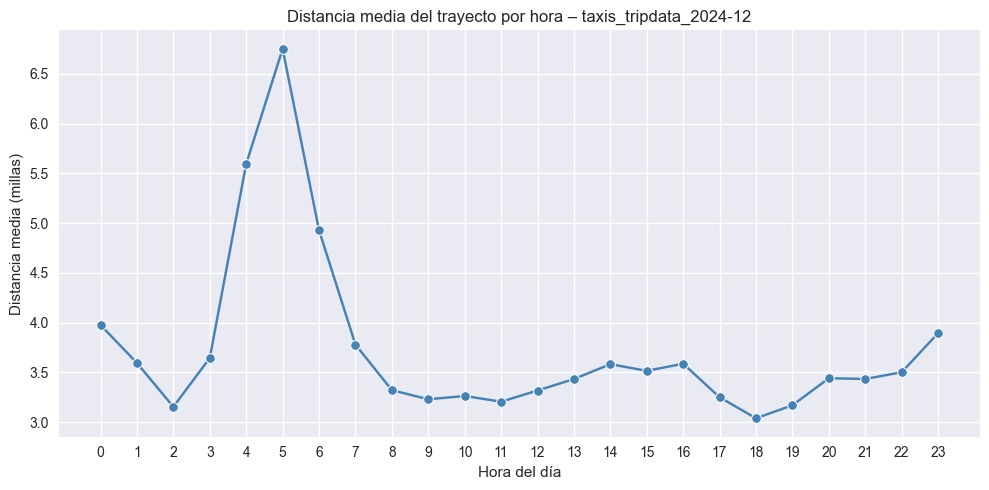

In [148]:
def plot_distancia_media_por_hora_dict(datasets_dict):
    """
    Grafica la distancia media (millas) del trayecto a lo largo del día para cada dataset del diccionario.

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}
    """
    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Verificar columnas necesarias
        if 'pickup_datetime' in df.columns and 'trip_distance' in df.columns:
            df['hora'] = pd.to_datetime(df['pickup_datetime'], errors='coerce').dt.hour
        else:
            print(f"❌ {nombre}: columnas necesarias no encontradas. Se omite.")
            continue

        df = df[df['trip_distance'] > 0]
        if df.empty:
            print(f"⚠️ {nombre}: sin datos válidos para calcular distancia.")
            continue

        media_por_hora = df.groupby('hora')['trip_distance'].mean()

        # Plot
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=media_por_hora.index, y=media_por_hora.values, marker="o", color="steelblue")
        plt.title(f"Distancia media del trayecto por hora – {nombre}")
        plt.xlabel("Hora del día")
        plt.ylabel("Distancia media (millas)")
        plt.xticks(range(0, 24))
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Generar gráficos de distancia media por hora para los datasets limpios
plot_distancia_media_por_hora_dict(cleaned_datasets)

## 2.4	Elige dos zonas cualesquiera de la ciudad y calcula la probabilidad de desplazarse de una zona a otra en menos de X minutos. (El valor X, así como las zonas deben ser fácilmente modificables).

In [168]:
from datetime import time

def calcular_probabilidad_desplazamiento_rapido_dict(
    datasets_dict, 
    origen,  # Puede ser ID (int) o tuple (lon, lat)
    destino, # Puede ser ID (int) o tuple (lon, lat)
    umbral_min=10,
    filtro_horas=None,
    rango_duracion_valida=(1, 180),
    incluir_analisis_temporal=False,
    column_groups=None,
    decimals=3  # Para agrupar zonas sintéticas
):
    """
    Calcula la probabilidad de que un trayecto entre dos zonas o coordenadas específicas
    dure menos de X minutos, para cada dataset del diccionario.

    Permite tanto IDs de zona como coordenadas redondeadas (lon, lat).
    """

    # Definición de columnas estándar y alternativas
    if column_groups is None:
        column_groups = {
            'PULocationID': ['PUlocationID', 'PULocationID'],
            'DOLocationID': ['DOlocationID', 'DOLocationID'],
            'pickup_datetime': [
                'tpep_pickup_datetime', 'lpep_pickup_datetime',
                'pickup_datetime', 'Trip_Pickup_DateTime',
                'request_datetime'
            ],
            'dropoff_datetime': [
                'tpep_dropoff_datetime', 'lpep_dropoff_datetime',
                'dropOff_datetime', 'dropoff_datetime', 'on_scene_datetime',
                'Trip_Dropoff_DateTime'
            ],
            'Start_Lon': ['Start_Lon', 'start_lon', 'pickup_longitude'],
            'Start_Lat': ['Start_Lat', 'start_lat', 'pickup_latitude'],
            'End_Lon': ['End_Lon', 'end_lon', 'dropoff_longitude'],
            'End_Lat': ['End_Lat', 'end_lat', 'dropoff_latitude'],
        }

    resultados = []
    analisis_temporal = {}

    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Normalización de nombres de columnas
        def encontrar_columna(column_group):
            for nombre_estandar in column_group:
                if nombre_estandar in df.columns:
                    return nombre_estandar
            return None
        
        columnas_encontradas = {}
        for col_estandar, alternativas in column_groups.items():
            col_encontrada = encontrar_columna([col_estandar] + alternativas)
            if col_encontrada:
                columnas_encontradas[col_estandar] = col_encontrada
            # No cortar el bucle, simplemente no añade esa columna

        # Renombrar solo las columnas encontradas
        df = df.rename(columns={v: k for k, v in columnas_encontradas.items()})

        # Fechas y duración
        if 'pickup_datetime' in df.columns and 'dropoff_datetime' in df.columns:
            df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
            df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce')
            df['duracion_min'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60
        else:
            print(f"⚠️ {nombre}: columnas de fecha no encontradas.")
            continue

        # Filtrar por franja horaria si se especifica
        if filtro_horas:
            hora_inicio, hora_fin = filtro_horas
            mask_hora = (df['pickup_datetime'].dt.time >= time(hora_inicio)) & \
                        (df['pickup_datetime'].dt.time <= time(hora_fin))
            df = df[mask_hora].copy()

        # Filtrar trayectos válidos (por duración)
        min_duracion, max_duracion = rango_duracion_valida

        # --- Identificadores de zona ---
        is_zones = 'PULocationID' in df.columns and 'DOLocationID' in df.columns and isinstance(origen, int) and isinstance(destino, int)
        # --- Coordenadas ---
        is_coords = all(c in df.columns for c in ['Start_Lon', 'Start_Lat', 'End_Lon', 'End_Lat']) and \
                    isinstance(origen, tuple) and isinstance(destino, tuple)

        if is_zones:
            trayectos = df[
                (df['PULocationID'] == origen) &
                (df['DOLocationID'] == destino) &
                (df['duracion_min'].notna()) &
                (df['duracion_min'] >= min_duracion) &
                (df['duracion_min'] <= max_duracion)
            ].copy()
        elif is_coords:
            df['PU_zone'] = list(zip(
                df['Start_Lon'].round(decimals),
                df['Start_Lat'].round(decimals)
            ))
            df['DO_zone'] = list(zip(
                df['End_Lon'].round(decimals),
                df['End_Lat'].round(decimals)
            ))
            trayectos = df[
                (df['PU_zone'] == tuple(round(x, decimals) for x in origen)) &
                (df['DO_zone'] == tuple(round(x, decimals) for x in destino)) &
                (df['duracion_min'].notna()) &
                (df['duracion_min'] >= min_duracion) &
                (df['duracion_min'] <= max_duracion)
            ].copy()
        else:
            print(f"⚠️ {nombre}: no se detecta ni columnas de zona ni de coordenadas compatibles.")
            continue

        total = len(trayectos)
        if total == 0:
            print(f"⚠️ {nombre}: sin trayectos válidos entre {origen} → {destino}.")
            continue

        rapidos = trayectos[trayectos['duracion_min'] < umbral_min]
        probabilidad = len(rapidos) / total

        resultados.append({
            'Dataset': nombre,
            'Trayectos': total,
            'Rápidos (< X min)': len(rapidos),
            'Probabilidad (%)': round(probabilidad * 100, 2),
            'Duración media (min)': round(trayectos['duracion_min'].mean(), 1),
            'Duración mediana (min)': round(trayectos['duracion_min'].median(), 1),
            'Desviación estándar': round(trayectos['duracion_min'].std(), 1)
        })

        # Análisis temporal adicional (opcional)
        if incluir_analisis_temporal and not trayectos.empty:
            trayectos['hora'] = trayectos['pickup_datetime'].dt.hour
            trayectos['dia_semana'] = trayectos['pickup_datetime'].dt.day_name()

            prob_por_hora = trayectos.groupby('hora')['duracion_min'] \
                .apply(lambda x: (x < umbral_min).mean()) \
                .reset_index()
            prob_por_hora.columns = ['Hora', 'Probabilidad']

            prob_por_dia = trayectos.groupby('dia_semana')['duracion_min'] \
                .apply(lambda x: (x < umbral_min).mean()) \
                .reset_index()
            prob_por_dia.columns = ['Día', 'Probabilidad']

            analisis_temporal[nombre] = {
                'por_hora': prob_por_hora,
                'por_dia': prob_por_dia,
                'datos_trayectos': trayectos[['pickup_datetime', 'duracion_min']]
            }

    df_resultados = pd.DataFrame(resultados)
    if incluir_analisis_temporal:
        return df_resultados, analisis_temporal
    else:
        return df_resultados

# Ejemplo: ¿Qué probabilidad hay de ir de Midtown Center (161) a West Chelsea (246) en menos de 15 minutos?
# Uso avanzado con análisis temporal
zona_origen = 161  # Midtown Center
zona_destino = 246 # West Chelsea
nombre_origen = zona_nombres.get(zona_origen, "Desconocido")
nombre_destino = zona_nombres.get(zona_destino, "Desconocido")

print(f"\nProbabilidad de llegar de {zona_origen} - {nombre_origen} a {zona_destino} - {nombre_destino} en menos de 15 min:")
resultados, analisis = calcular_probabilidad_desplazamiento_rapido_dict(
    datasets_dict=cleaned_datasets,
    origen=161,
    destino=246,
    umbral_min=15,
    filtro_horas=(7, 20),  # Solo trayectos entre 7am y 8pm
    incluir_analisis_temporal=True
)
print(resultados)



Probabilidad de llegar de 161 - Midtown Center a 246 - West Chelsea/Hudson Yards en menos de 15 min:
                  Dataset  Trayectos  Rápidos (< X min)  Probabilidad (%)  \
0  taxis_tripdata_2024-02       2218                904             40.76   
1  taxis_tripdata_2024-12       2333                516             22.12   

   Duración media (min)  Duración mediana (min)  Desviación estándar  
0                  16.8                    16.1                  5.2  
1                  21.4                    20.2                  7.8  


## 2.5	Repite los apartados 1.1, 1.2, 1.3, 1.4, 2.1, 2.2, 2.3 y 2.4 con un dataset del mismo mes, pero del año 2009. Comenta todas las diferencias que vayas encontrando.


### 1.1	Primer examen preliminar del dataset.  ¿En qué formato está el dataset y qué tiene que ver este formato con Big Data? ¿Qué parámetros hay en el dataset? ¿Cuál es su significado? ¿Existen valores aparentemente incorrectos?



_El dataset tiene otras columnas y solo yellow, no existe el green taxi.  Se normalizan las columnas_

#### Cargamos el Dataset Febrero de 2009

In [149]:
# Ruta base de trip-data
data_path = "https://d37ci6vzurychx.cloudfront.net/trip-data/"

# Cargar datasets originales de 2009
original_dataset_2009_02= {"yellow_df_2009_02":cargar_parquet_local_o_url("original_parquets/yellow_tripdata_2009-02.parquet", data_path + "yellow_tripdata_2009-02.parquet")}


✅ Cargado desde archivo local: original_parquets/yellow_tripdata_2009-02.parquet


In [150]:
# Renombrar columnas de datasets originales
renamed_dataset_2009_02 = rename_column_names_with_flags(original_dataset_2009_02, column_groups)

In [151]:
# Mostrar columnas renombradas
print(f"Columnas del Dataset yellow_tripdata_2024-02 renombrado {renamed_datasets['yellow_tripdata_2024-02'].columns}")
print(f"Columnas del Dataset renamed_dataset_2009_02 renombrado {renamed_dataset_2009_02['yellow_df_2009_02'].columns}")

Columnas del Dataset yellow_tripdata_2024-02 renombrado Index(['PULocationID', 'DOLocationID', 'pickup_datetime', 'dropoff_datetime',
       'trip_distance', 'total_amount', 'fare_amount', 'airport_fee', 'extra',
       'tolls', 'tips', 'payment_type', 'RatecodeID', 'VendorID',
       'passenger_count', 'store_and_fwd_flag', 'same_location_flag',
       'suspicious_location_flag', 'mta_tax', 'improvement_surcharge',
       'congestion_surcharge'],
      dtype='object')
Columnas del Dataset renamed_dataset_2009_02 renombrado Index(['Start_Lon', 'Start_Lat', 'End_Lon', 'End_Lat', 'pickup_datetime',
       'dropoff_datetime', 'trip_distance', 'total_amount', 'fare_amount',
       'extra', 'tolls', 'tips', 'payment_type', 'RatecodeID', 'VendorID',
       'passenger_count', 'store_and_fwd_flag', 'same_location_flag',
       'suspicious_location_flag', 'mta_tax'],
      dtype='object')


In [152]:
# Liberar memoria
del original_datasets

In [153]:
# Limpiar dataset 2009-02 
cleaned_dataset_2009_02= limpiar_dataset_integrado(renamed_dataset_2009_02, zona_nombres)


🔄 Procesando: yellow_df_2009_02
✅ yellow_df_2009_02: limpieza completada con 12602601 registros válidos.


In [154]:
# ¿Existen valores aparentemente incorrectos?
# Verificación de calidad de columnas
df_errores_2009_02 = analizar_valores_invalidos_dict(cleaned_dataset_2009_02)
display(df_errores_2009_02)

🔍 Analizando: yellow_df_2009_02


,Dataset,Tipo de error,Nº de registros
0,yellow_df_2009_02,Pasajeros = nulos,0
1,yellow_df_2009_02,Pasajeros < 0,0
2,yellow_df_2009_02,Distancia = nula,0
3,yellow_df_2009_02,Distancia <= 0,0
4,yellow_df_2009_02,Pickup/dropoff = nulos,0
5,yellow_df_2009_02,Dropoff < Pickup,0
6,yellow_df_2009_02,Duración = 0 min,0
7,yellow_df_2009_02,Total_amount = nulo,0
8,yellow_df_2009_02,Total_amount <= 0,0
9,yellow_df_2009_02,Start_Lon = nulo,0


#### 1.2 Plot de trayectos entre las 20 zonas más activas

In [155]:
# Heatmap de trayectos entre las 20 zonas más activas, este gráfico es pesado y no tiene un mapeo de las localizaciones
# respecto a las zonas de NYC, sería útil crear el mapeo de las zonas
# para poder ver la relación entre las zonas de origen y destino
heatmap_zonas_o_coordenadas(cleaned_dataset_2009_02)

C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_17220\1063339578.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_17220\1063339578.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 1.3 Haz un Diagrama de Sankey que muestre los trayectos entre las 5 zonas más populares (las que tienen más trayectos). 

In [156]:
# Gráfico de Sankey para trayectos entre las 20 zonas más activas de febrero 2009
plot_sankey_top5_dict(cleaned_dataset_2009_02, top_n=5, decimals=3)


[Figure({
     'data': [{'link': {'source': [4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 0,
                                   0, 0, 0, 0, 2, 2, 2, 2, 2],
                        'target': [4, 3, 1, 0, 2, 4, 3, 1, 0, 2, 4, 3, 1, 0, 2, 4,
                                   3, 1, 0, 2, 4, 3, 1, 0, 2],
                        'value': [17, 6, 1, 7, 8, 16, 38, 8, 9, 6, 7, 6, 19, 18, 7,
                                  5, 4, 16, 31, 12, 6, 2, 5, 9, 12]},
               'node': {'label': [(-73.991, 40.75), (-73.992, 40.75), (-73.991,
                                  40.751), (-73.994, 40.751), (-73.995, 40.75)],
                        'line': {'color': 'black', 'width': 0.5},
                        'pad': 15,
                        'thickness': 20},
               'type': 'sankey'}],
     'layout': {'font': {'size': 12},
                'template': '...',
                'title': {'text': 'Trayectos entre las 5 zonas más populares – yellow_df_2009_02'}}
 })]

### 1.4	Mejora la visualización anterior con un heat map. Ayúdate de los Zone Map…

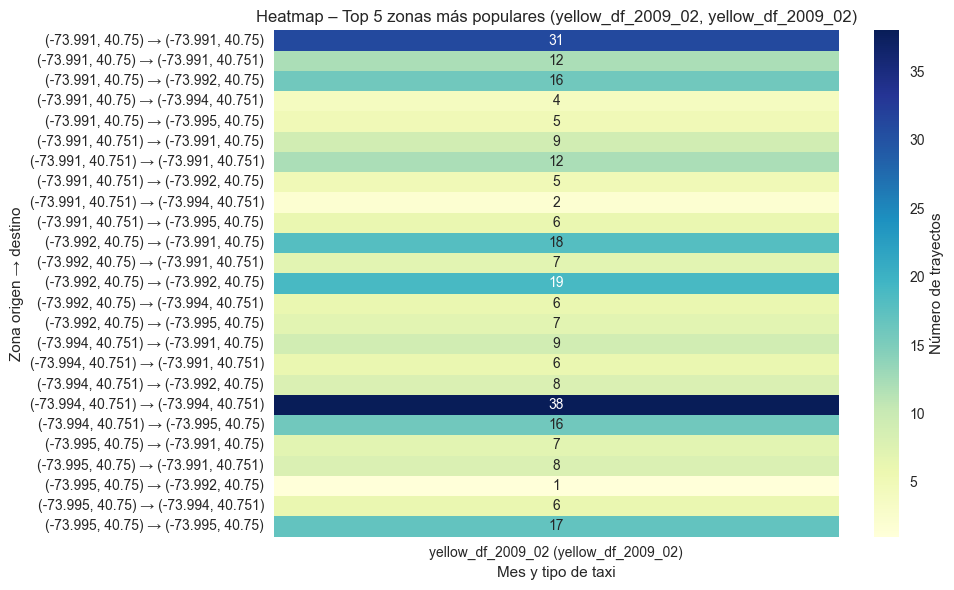

In [157]:
# Generamos heatmaps para los datasets Limpios
plot_heatmap_top5_dict(cleaned_dataset_2009_02)

### 2.1	¿Cuál es el trayecto en el que la relación precio/km es más alta? ¿Cuál es el trayecto en el que la relación tiempo/km es más alta? ¿Cuál es el trayecto en el que la relación precio/tiempo es más alta?

In [158]:
# 2.1 ¿Cuál es el trayecto en el que la relación precio/km es más alta?
print("\n📊 ¿Cuál es el trayecto en el que la relación precio/km es más alta?")
trayecto_mayor_precio_por_km(cleaned_dataset_2009_02, zona_nombres)


📊 ¿Cuál es el trayecto en el que la relación precio/km es más alta?


,Dataset,Origen,Destino,Distancia (mi),Precio ($),Precio/km ($),Duración (min),Hora Punta,Día,Recargos,Precio Teórico ($),Ratio Real/Teórico
0,yellow_df_2009_02,"(-73.785, 40.649)","(-73.801, 40.646)",0.6,45.0,46.602955,18.116667,Sí,Thursday,Ninguno,17.181667,2.619071
1,GLOBAL (yellow_df_2009_02),"(-73.785, 40.649)","(-73.801, 40.646)",0.6,45.0,46.602955,18.116667,Sí,Thursday,Ninguno,17.181667,2.619071


### 2.1 ¿Cuál es el trayecto en el que la relación tiempo/km es más alta? 

In [159]:
# 2.1 ¿Cuál es el trayecto en el que la relación tiempo/km es más alta? 
print("\n📊 ¿Cuál es el trayecto en el que la relación tiempo/km es más alta? ")
trayecto_mayor_duracion_por_km(cleaned_dataset_2009_02, zona_nombres)


📊 ¿Cuál es el trayecto en el que la relación tiempo/km es más alta? 


,Dataset,Origen,Destino,Distancia (mi),Duración (min),Min/km,Hora Punta
0,yellow_df_2009_02,"(-73.991, 40.75)","(-73.885, 40.773)",0.87,28.0,32.183908,No
1,GLOBAL (yellow_df_2009_02),"(-73.991, 40.75)","(-73.885, 40.773)",0.87,28.0,32.183908,No


### 2.1  ¿Cuál es el trayecto en el que la relación precio/tiempo es más alta? 

In [160]:
# 2.1  ¿Cuál es el trayecto en el que la relación precio/tiempo es más alta? 
def trayecto_mayor_precio_por_minuto(datasets_dict, zona_nombres=None, decimals=3):
    """
    Encuentra el trayecto con la mayor relación precio por minuto para cada dataset y a nivel global,
    mostrando orígenes y destinos por zona o coordenadas.

    Devuelve:
        DataFrame resumen por dataset y global, mostrando outliers solo si han pasado la limpieza.
    """
    resumen = []
    global_max = None
    global_name = None

    for nombre, df in datasets_dict.items():
        df = df.copy()
        # Usar la columna ya ajustada por tarifa mínima y limpieza: 'Precio ($)'
        if "Precio ($)" not in df.columns or "trip_duration_min" not in df.columns:
            print(f"⚠️ {nombre}: faltan columnas necesarias. Se omite.")
            continue

        df = df[(df["trip_duration_min"] > 0) & (df["Precio ($)"] > 0)].copy()

        # Calcula $/min si no existe, para asegurar robustez
        if "$/min" not in df.columns:
            df["$/min"] = df["Precio ($)"] / df["trip_duration_min"]

        # Filtra por el criterio de limpieza final, por si acaso algún registro suelto lo pasó
        df = df[df["$/min"] <= 5]

        if df.empty:
            print(f"⚠️ {nombre}: sin registros válidos para calcular $/min.")
            continue

        # Zonas modernas (PULocationID/DOLocationID)
        if "PULocationID" in df.columns and "DOLocationID" in df.columns:
            top = df.loc[df["$/min"].idxmax()]
            origen_str = f"{int(top['PULocationID'])} - {zona_nombres.get(int(top['PULocationID']), 'Desconocido') if zona_nombres else int(top['PULocationID'])}"
            destino_str = f"{int(top['DOLocationID'])} - {zona_nombres.get(int(top['DOLocationID']), 'Desconocido') if zona_nombres else int(top['DOLocationID'])}"
        # Coordenadas antiguas
        elif all(col in df.columns for col in ["Start_Lon", "Start_Lat", "End_Lon", "End_Lat"]):
            # Zonas sintéticas: coordenadas redondeadas
            df["PU_zone"] = list(zip(df["Start_Lon"].round(decimals), df["Start_Lat"].round(decimals)))
            df["DO_zone"] = list(zip(df["End_Lon"].round(decimals), df["End_Lat"].round(decimals)))
            top = df.loc[df["$/min"].idxmax()]
            origen_str = str(top["PU_zone"])
            destino_str = str(top["DO_zone"])
        else:
            print(f"⚠️ {nombre}: columnas de zona ni coordenadas detectadas. Se omite.")
            continue

        resumen.append({
            "Dataset": nombre,
            "Origen": origen_str,
            "Destino": destino_str,
            "Duración (min)": top["trip_duration_min"],
            "Precio ($)": top["Precio ($)"],
            "$/min": top["$/min"]
        })

        if global_max is None or top["$/min"] > global_max["$/min"]:
            global_max = top
            global_name = nombre
            global_origen_str = origen_str
            global_destino_str = destino_str

    if global_max is not None:
        resumen.append({
            "Dataset": f"GLOBAL ({global_name})",
            "Origen": global_origen_str,
            "Destino": global_destino_str,
            "Duración (min)": global_max["trip_duration_min"],
            "Precio ($)": global_max["Precio ($)"],
            "$/min": global_max["$/min"]
        })

    return pd.DataFrame(resumen)

# Ejecutar la función para encontrar el trayecto con mayor precio por minuto
print("\n📊 Trayecto con la relación precio/minuto más alta:")
trayecto_mayor_precio_por_minuto(cleaned_dataset_2009_02, zona_nombres)


📊 Trayecto con la relación precio/minuto más alta:


,Dataset,Origen,Destino,Duración (min),Precio ($),$/min
0,yellow_df_2009_02,"(-74.002, 40.746)","(-73.998, 40.742)",1.4,7.0,5.0
1,GLOBAL (yellow_df_2009_02),"(-74.002, 40.746)","(-73.998, 40.742)",1.4,7.0,5.0


### 2.2	¿Cuál es el trayecto en el que la relación tiempo/km es más baja? 

In [161]:

print("\n📊 Trayecto con la relación precio/km más baja:")
trayecto_menor_precio_por_km(cleaned_dataset_2009_02, zona_nombres, min_distance=0.1)


📊 Trayecto con la relación precio/km más baja:


,Dataset,Origen,Destino,Distancia (mi),Precio ($),Precio/km ($)
0,yellow_df_2009_02,"(-74.009, 40.714)","(-73.871, 40.774)",30.0,34.1,0.706294
1,GLOBAL (yellow_df_2009_02),"(-74.009, 40.714)","(-73.871, 40.774)",30.0,34.1,0.706294


### 2.2 ¿Cuál es el trayecto en el que la relación tiempo/km es más baja? 

In [164]:
# Ejecutar la función para encontrar el trayecto con menor tiempo/km
print("\n📊 Trayecto con la relación tiempo/km más baja:")
trayecto_menor_tiempo_por_km(cleaned_dataset_2009_02)


📊 Trayecto con la relación tiempo/km más baja:


,Dataset,Origen,Destino,Distancia (mi),Duración (min),Min/km
0,yellow_df_2009_02,"(-73.871, 40.774)","(-73.988, 40.72)",9.32,9.0,0.965665
1,GLOBAL (yellow_df_2009_02),"(-73.871, 40.774)","(-73.988, 40.72)",9.32,9.0,0.965665


### 2.2 ¿Cuál es el trayecto en el que la relación precio/tiempo es más baja?

In [165]:
# ¿Cuál es el trayecto en el que la relación precio/tiempo es más baja?
print("\n📊 Trayecto con la relación precio/tiempo más baja:")
trayecto_menor_precio_por_minuto(cleaned_dataset_2009_02, zona_nombres)


📊 Trayecto con la relación precio/tiempo más baja:


,Dataset,Origen,Destino,Duración (min),Precio ($),Precio/min ($)
0,yellow_df_2009_02,"(-73.954, 40.766)","(-73.984, 40.758)",63.816667,16.3,0.255419
1,GLOBAL (yellow_df_2009_02),"(-73.954, 40.766)","(-73.984, 40.758)",63.816667,16.3,0.255419


### 2.3 Muestra la evolución del tiempo medio de trayecto a lo largo del día

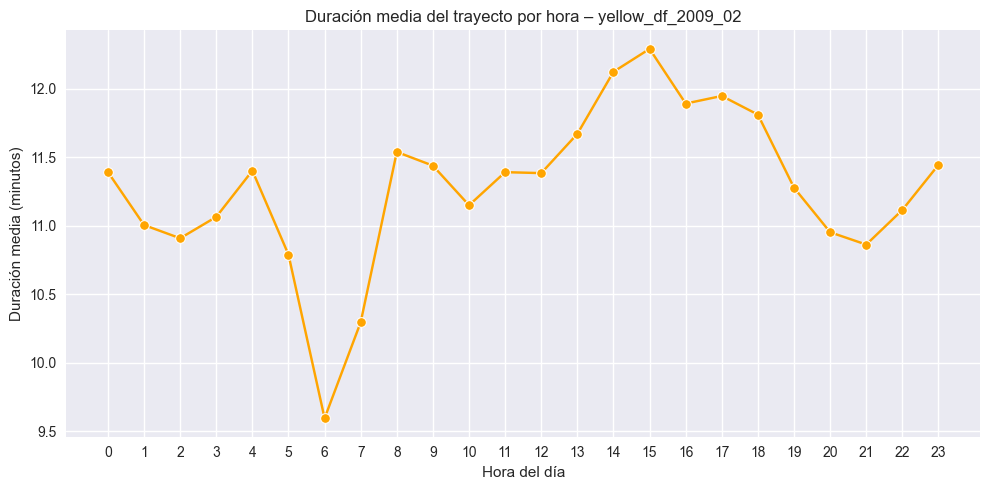

In [166]:
# 2.3	Muestra la evolución del tiempo medio de trayecto a lo largo del día. 
print("\n📊 evolución del tiempo medio de trayecto a lo largo del día:")
plot_tiempo_medio_por_hora_dict(cleaned_dataset_2009_02)

### 2.4	Elige dos zonas cualesquiera de la ciudad y calcula la probabilidad de desplazarse de una zona a otra en menos de X minutos. (El valor X, así como las zonas deben ser fácilmente modificables).

In [169]:
# calcular la probabilidad de desplazamiento rápido entre dos zonas
print("\n📊 Probabilidad de desplazamiento rápido entre dos zonas:")
resultados = calcular_probabilidad_desplazamiento_rapido_dict(
    cleaned_dataset_2009_02,
    origen=(-73.991, 40.75),     # Ejemplo: zona sintética
    destino=(-73.992, 40.75),    # Ejemplo: otra zona sintética
    umbral_min=10,
    decimals=3                   # Asegúrate de que coincidan los decimales de agrupación
)
print(resultados)



📊 Probabilidad de desplazamiento rápido entre dos zonas:
             Dataset  Trayectos  Rápidos (< X min)  Probabilidad (%)  \
0  yellow_df_2009_02         16                  5             31.25   

   Duración media (min)  Duración mediana (min)  Desviación estándar  
0                  14.8                    12.5                 10.7  


# Tercera Parte: Análisis Predictivo

## 3.1	¿Cuáles son las zonas donde es más probable coger un taxi en función de la hora del día?


In [170]:
def analizar_probabilidad_pickup_por_zona(datasets_dict):
    """
    Calcula y visualiza las zonas con más probabilidad de coger un taxi según la hora del día.
    Incluye:
    - Heatmap general de todas las zonas.
    - Gráfico de líneas para el top 10 zonas.
    - Heatmap restringido al top 20 zonas.
    """
    # Concatenar todos los datasets que tengan pickup_datetime y PULocationID
    data = []
    for nombre, df in datasets_dict.items():
        if 'pickup_datetime' in df.columns and 'PULocationID' in df.columns:
            temp = df[['pickup_datetime', 'PULocationID']].copy()
            temp["dataset"] = nombre
            data.append(temp)
    if not data:
        print("❌ Ningún dataset tiene las columnas requeridas.")
        return
    
    df_all = pd.concat(data)
    df_all['pickup_datetime'] = pd.to_datetime(df_all['pickup_datetime'], errors='coerce')
    df_all = df_all.dropna(subset=['pickup_datetime', 'PULocationID'])
    df_all['hour'] = df_all['pickup_datetime'].dt.hour

    # Calcular número de pickups por zona y hora
    pickup_counts = df_all.groupby(['hour', 'PULocationID']).size().reset_index(name='count')

    # Normalizar por hora (para obtener probabilidad relativa)
    total_por_hora = pickup_counts.groupby('hour')['count'].transform('sum')
    pickup_counts['probabilidad'] = pickup_counts['count'] / total_por_hora

    # Pivot para heatmap completo
    pivot = pickup_counts.pivot(index='PULocationID', columns='hour', values='probabilidad').fillna(0)

    # Visualización 1: Gráfico de líneas para top 10 zonas
    top_zonas = df_all["PULocationID"].value_counts().head(10).index
    df_top = df_all[df_all["PULocationID"].isin(top_zonas)]
    top_line_df = df_top.groupby(["hour", "PULocationID"]).size().unstack().fillna(0)

    plt.figure(figsize=(12, 6))
    top_line_df.plot(marker="o")
    plt.title("📈 Evolución horaria de los 10 PULocationID más activos")
    plt.xlabel("Hora del día")
    plt.ylabel("Número de pickups")
    plt.grid(True)
    plt.legend(title="Zona", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Visualización 2: Heatmap de top 20 zonas
    top_20 = df_all["PULocationID"].value_counts().head(20).index
    filtered = df_all[df_all["PULocationID"].isin(top_20)].copy()
    filtered["hour"] = pd.to_datetime(filtered["pickup_datetime"]).dt.hour
    heat_df = filtered.groupby(["PULocationID", "hour"]).size().unstack(fill_value=0)
    heat_df = heat_df.div(heat_df.sum(axis=1), axis=0)  # Normalizar por zona

    plt.figure(figsize=(12, 6))
    sns.heatmap(heat_df, cmap="YlOrBr", annot=True, fmt=".2f")
    plt.title("🔥 Probabilidad normalizada por zona (Top 20)")
    plt.xlabel("Hora del día")
    plt.ylabel("Zona")
    plt.tight_layout()
    plt.show()

C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_17220\2298346317.py:47: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.



<Figure size 1200x600 with 0 Axes>

C:\Users\Intekmedical\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.



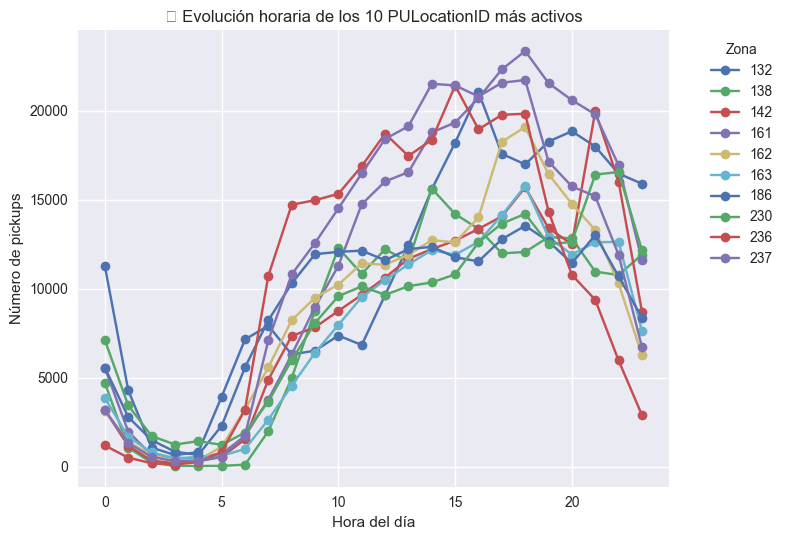

C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_17220\2298346317.py:62: UserWarning:

Glyph 128293 (\N{FIRE}) missing from font(s) Arial.

C:\Users\Intekmedical\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128293 (\N{FIRE}) missing from font(s) Arial.



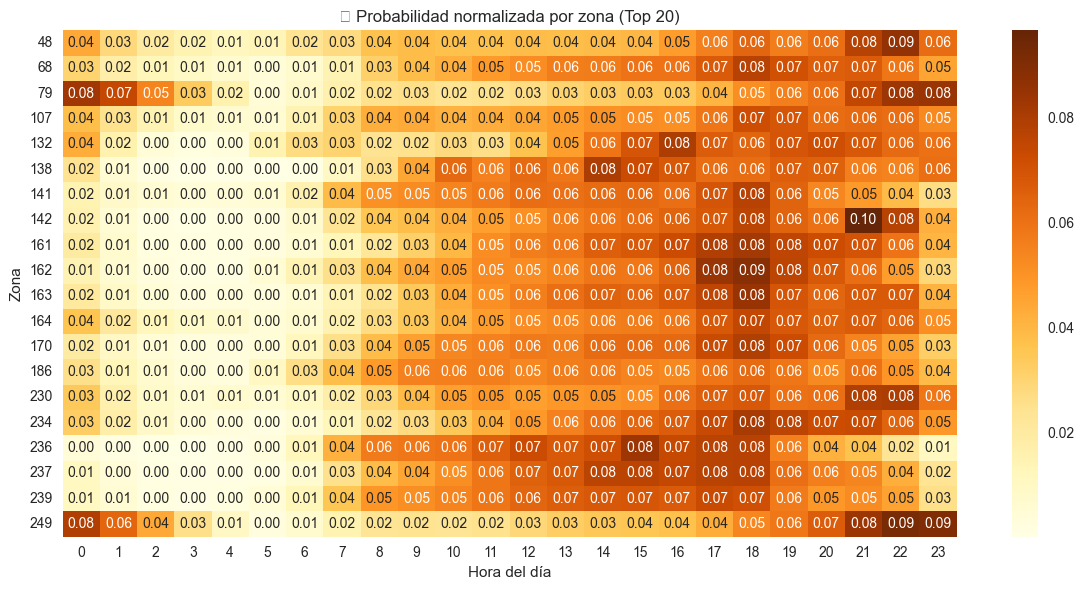

In [171]:
# Ejecutar la función para analizar la probabilidad de recoger un taxi por hora y zona
analizar_probabilidad_pickup_por_zona(cleaned_datasets)


## 3.2	¿Cuál es la mejor hora del día para ir al aeropuerto?

Objetivo: Saber a qué hora los trayectos al aeropuerto son más rápidos.

In [ ]:
def analizar_horas_para_ir_aeropuerto(dict_datasets, zona_nombres):

    # 1. Detectar zonas de aeropuerto automáticamente
    aeropuerto_ids = [
        zona_id for zona_id, nombre in zona_nombres.items()
        if isinstance(nombre, str) and (
            'airport' in nombre.lower() or 'jfk' in nombre.lower() or 'laguardia' in nombre.lower()
        )
    ]

    if not aeropuerto_ids:
        print("❌ No se detectaron zonas de aeropuerto en zona_nombres.")
        return

    print("🛫 IDs de aeropuerto detectados:", aeropuerto_ids)

    data = []

    # 2. Recolectar trayectos a aeropuerto
    for nombre, df in dict_datasets.items():
        if all(col in df.columns for col in ['pickup_datetime', 'DOLocationID', 'trip_duration_min']):
            temp = df[['pickup_datetime', 'DOLocationID', 'trip_duration_min']].copy()
            temp = temp[temp['DOLocationID'].isin(aeropuerto_ids)]
            temp['hour'] = pd.to_datetime(temp['pickup_datetime'], errors='coerce').dt.hour
            temp.dropna(subset=['hour', 'trip_duration_min'], inplace=True)
            data.append(temp)

    if not data:
        print("❌ No hay trayectos con destino a aeropuerto.")
        return

    df_aeropuerto = pd.concat(data)

    # 3. Agrupaciones
    duracion_media = df_aeropuerto.groupby('hour')['trip_duration_min'].mean().reset_index(name='duración_media_min')
    frecuencia = df_aeropuerto.groupby('hour').size().reset_index(name='n_trayectos')

    resumen = pd.merge(duracion_media, frecuencia, on='hour')

    # 4. Selección de mejor hora
    top_frecuencia = resumen['n_trayectos'].quantile(0.7)
    candidatos = resumen[resumen['n_trayectos'] >= top_frecuencia]
    mejor_hora = candidatos.sort_values('duración_media_min').iloc[0]

    # 5. Visualización
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle("🛫 Análisis de la mejor hora para ir al aeropuerto", fontsize=16)

    sns.lineplot(x='hour', y='duración_media_min', data=resumen, marker='o', ax=axs[0], color='orange')
    axs[0].axvline(mejor_hora['hour'], color='green', linestyle='--', label=f'Mejor hora: {int(mejor_hora["hour"])}h')
    axs[0].set_title("Duración media del trayecto por hora")
    axs[0].set_ylabel("Duración media (min)")
    axs[0].set_xlabel("Hora")
    axs[0].legend()
    axs[0].grid(True)

    sns.barplot(x='hour', y='n_trayectos', data=resumen, ax=axs[1], palette='Blues_d')
    axs[1].axvline(mejor_hora['hour'], color='green', linestyle='--')
    axs[1].set_title("Frecuencia de trayectos al aeropuerto por hora")
    axs[1].set_ylabel("Nº de trayectos")
    axs[1].set_xlabel("Hora")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # 6. Imprimir resumen
    print("\n📝 Recomendación:")
    print(f"La mejor hora para ir al aeropuerto es las **{int(mejor_hora['hour'])}:00 h**.")
    print(f"- Duración media estimada: {mejor_hora['duración_media_min']:.1f} minutos.")
    print(f"- Número de trayectos registrados en esa hora: {mejor_hora['n_trayectos']}.")

    return resumen



🛫 IDs de aeropuerto detectados: [1, 132, 138]


C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_17220\2747464014.py:57: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_17220\2747464014.py:63: UserWarning:

Glyph 128747 (\N{AIRPLANE DEPARTURE}) missing from font(s) Arial.

C:\Users\Intekmedical\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128747 (\N{AIRPLANE DEPARTURE}) missing from font(s) Arial.



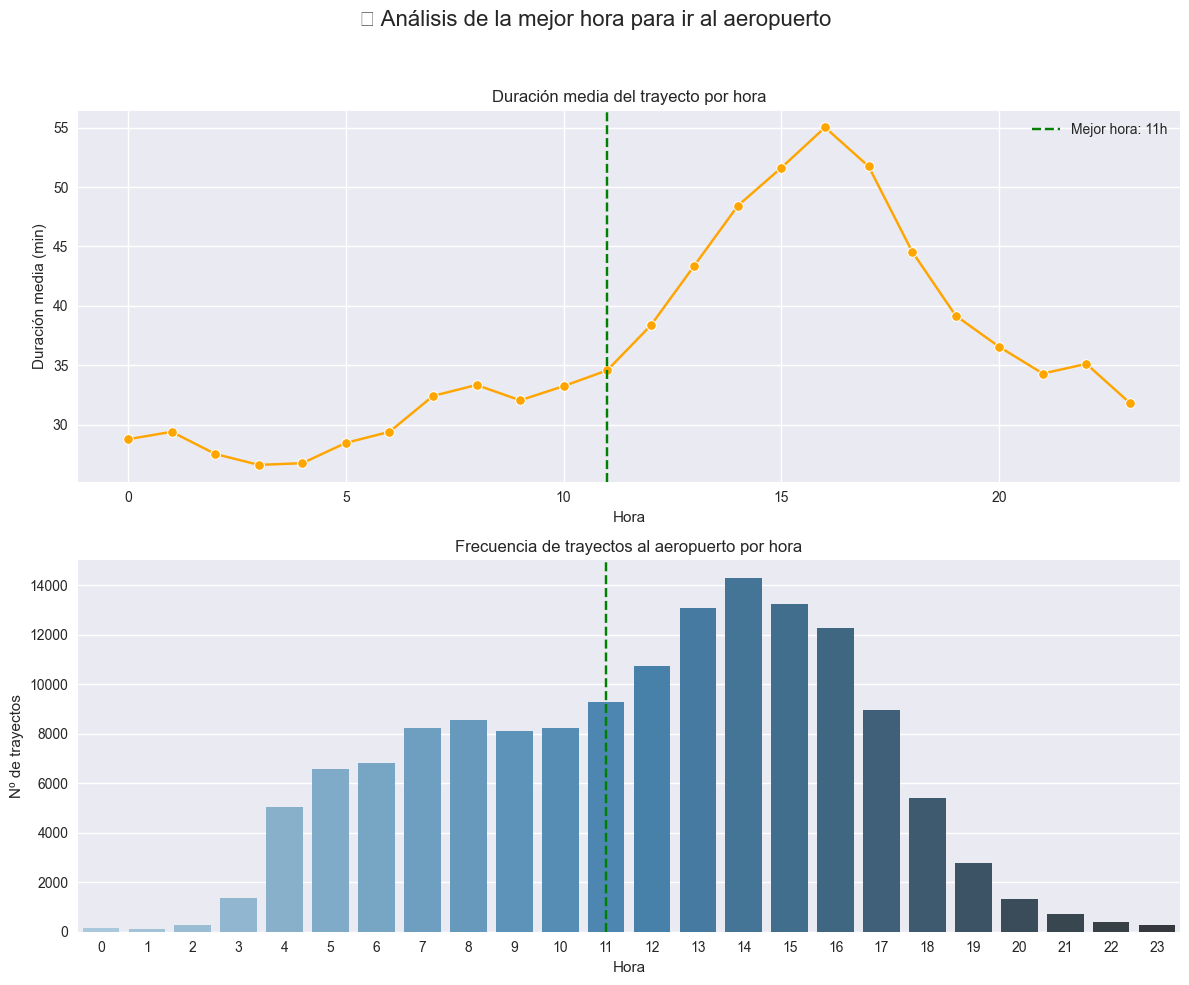


📝 Recomendación:
La mejor hora para ir al aeropuerto es las **11:00 h**.
- Duración media estimada: 34.6 minutos.
- Número de trayectos registrados en esa hora: 9302.0.


In [ ]:
resumen_aeropuerto = analizar_horas_para_ir_aeropuerto(cleaned_datasets, zona_nombres)

## 3.3	Diseña un modelo que, dada una hora, una zona origen, y una zona destino, predice la duración del trayecto y su coste. Muestra la relevancia de los atributos del dataset.

## Predicción de duración y coste del trayecto dada la hora, la zona de origen y la zona de destino.
- Dado:
    - hora (extraída de pickup_datetime)
    - zona origen (PULocationID)
    - zona destino (DOLocationID)

- Predecir:
    - trip_duration_min
    - total_amount

In [173]:
def preparar_dataset_modelo_total_amount_log(datasets_dict):
    """
    Prepara los datos a partir de un diccionario de datasets para predecir duración y total_amount.
    - Combina todos los DataFrames en uno.
    - Filtra y limpia outliers.
    - Crea variables: hora, día_semana, log_duración.
    - Devuelve X, y_duracion_log, y_total, df final.
    """
    # Unir todos los datasets válidos en uno
    dfs = []
    for nombre, df in datasets_dict.items():
        if {"pickup_datetime", "PULocationID", "DOLocationID", "trip_distance", "total_amount"}.issubset(df.columns):
            dfs.append(df[["pickup_datetime", "PULocationID", "DOLocationID", "trip_distance", "total_amount", "trip_duration_min"]].copy())
    if not dfs:
        raise ValueError("No hay datasets válidos con las columnas requeridas.")
    
    df = pd.concat(dfs, ignore_index=True)
    
    # Limpiar registros inválidos
    df = df.dropna(subset=["pickup_datetime", "PULocationID", "DOLocationID", "trip_distance", "total_amount", "trip_duration_min"])
    df = df[
        (df["trip_distance"] > 0) & 
        (df["total_amount"] > 0) & 
        (df["trip_duration_min"] > 0)
    ].copy()
    
    # Transformaciones
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce")
    df["hour"] = df["pickup_datetime"].dt.hour
    df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
    df["log_duration"] = np.log1p(df["trip_duration_min"])
    
    # Preparar features y targets
    X = df[["hour", "day_of_week", "PULocationID", "DOLocationID", "trip_distance"]]
    y_duracion_log = df["log_duration"]
    y_total = df["total_amount"]
    
    return X, y_duracion_log, y_total, df

# Probamos si carga correctamente
X, y_duracion_log, y_total, df_modelo = preparar_dataset_modelo_total_amount_log(cleaned_datasets)


#### Entrenar y evaluar los modelos de RandomForest: duración y coste

In [174]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

def entrenar_y_evaluar_modelos(df_modelo):
    """
    Entrena y evalúa dos modelos de RandomForest: duración y coste.
    """
    # Variables predictoras y objetivo
    X = df_modelo[["hour", "PULocationID", "DOLocationID"]]
    y_duracion = df_modelo["trip_duration_min"]
    y_precio = df_modelo["total_amount"]

    # Codificación categórica con OneHot
    preprocesador = ColumnTransformer(
        transformers=[
            ("onehot", OneHotEncoder(handle_unknown="ignore"), ["PULocationID", "DOLocationID"])
        ],
        remainder='passthrough'  # deja pasar la hora
    )

    # Modelo para duración
    modelo_duracion = Pipeline([
        ("preprocesado", preprocesador),
        ("rf", RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1))
    ])

    # Modelo para precio
    modelo_precio = Pipeline([
        ("preprocesado", preprocesador),
        ("rf", RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1))
    ])

    # División train-test
    X_train, X_test, y_train_d, y_test_d = train_test_split(X, y_duracion, test_size=0.2, random_state=42)
    _, _, y_train_p, y_test_p = train_test_split(X, y_precio, test_size=0.2, random_state=42)

    print("🔁 Entrenando modelo de duración...")
    modelo_duracion.fit(X_train, y_train_d)

    print("🔁 Entrenando modelo de precio total...")
    modelo_precio.fit(X_train, y_train_p)

    # Predicciones
    y_pred_d = modelo_duracion.predict(X_test)
    y_pred_p = modelo_precio.predict(X_test)

    # Evaluación
    print("\n📊 Evaluación modelo de duración:")
    print(f"- MAE: {mean_absolute_error(y_test_d, y_pred_d):.2f} minutos")
    print(f"- RMSE: {np.sqrt(mean_squared_error(y_test_d, y_pred_d)):.2f}")
    print(f"- R²: {r2_score(y_test_d, y_pred_d):.2f}")

    print("\n📊 Evaluación modelo de precio total:")
    print(f"- MAE: {mean_absolute_error(y_test_p, y_pred_p):.2f} $")
    print(f"- RMSE: {np.sqrt(mean_squared_error(y_test_p, y_pred_p)):.2f}")
    print(f"- R²: {r2_score(y_test_p, y_pred_p):.2f}")

    return modelo_duracion, modelo_precio


In [175]:
# Entrenar y evaluar los modelos (duración y precio)
# 12minutos
modelo_duracion, modelo_precio = entrenar_y_evaluar_modelos(df_modelo)

🔁 Entrenando modelo de duración...
🔁 Entrenando modelo de precio total...

📊 Evaluación modelo de duración:
- MAE: 7.56 minutos
- RMSE: 10.66
- R²: 0.40

📊 Evaluación modelo de precio total:
- MAE: 8.23 $
- RMSE: 11.84
- R²: 0.69


#### Predecir trayecto 

In [176]:
def predecir_trayecto(modelo_duracion, modelo_precio, hora, zona_origen, zona_destino):
    """
    Realiza la predicción para un trayecto y muestra la importancia de los atributos.

    Parámetros:
        modelo_duracion: modelo entrenado para duración
        modelo_precio: modelo entrenado para coste
        hora: int (0-23)
        zona_origen: int (PULocationID)
        zona_destino: int (DOLocationID)

    Retorna:
        dict con predicciones y DataFrame con importancia de atributos
    """
    entrada = pd.DataFrame([{
        "hour": hora,
        "PULocationID": zona_origen,
        "DOLocationID": zona_destino
    }])

    # Predicción
    duracion_pred = modelo_duracion.predict(entrada)[0]
    precio_pred = modelo_precio.predict(entrada)[0]

    # Extraer importancias del modelo RandomForest (tras preprocessing)
    rf_duracion = modelo_duracion.named_steps["rf"]
    rf_precio = modelo_precio.named_steps["rf"]
    preproc = modelo_duracion.named_steps["preprocesado"]
    feature_names = preproc.get_feature_names_out()

    importancias_duracion = pd.Series(rf_duracion.feature_importances_, index=feature_names)
    importancias_precio = pd.Series(rf_precio.feature_importances_, index=feature_names)

    top_importancia_duracion = importancias_duracion.sort_values(ascending=False).head(10)
    top_importancia_precio = importancias_precio.sort_values(ascending=False).head(10)

    return {
        "duracion_minutos_estimada": round(duracion_pred, 2),
        "precio_estimado_dolares": round(precio_pred, 2),
        "importancia_duracion": top_importancia_duracion,
        "importancia_precio": top_importancia_precio
    }


In [177]:
resultado = predecir_trayecto(modelo_duracion, modelo_precio, 14, 132, 230)
print(f"🕒 Duración estimada: {resultado['duracion_minutos_estimada']} min")
print(f"💵 Precio estimado: {resultado['precio_estimado_dolares']} $")
print("\n📊 Atributos más relevantes para duración:")
print(resultado["importancia_duracion"])
print("\n📊 Atributos más relevantes para precio:")
print(resultado["importancia_precio"])


🕒 Duración estimada: 74.94 min
💵 Precio estimado: 84.91 $

📊 Atributos más relevantes para duración:
onehot__PULocationID_132    0.441502
onehot__DOLocationID_132    0.165413
onehot__PULocationID_138    0.127042
remainder__hour             0.113043
onehot__DOLocationID_138    0.036952
onehot__DOLocationID_1      0.028066
onehot__PULocationID_70     0.014571
onehot__DOLocationID_230    0.013779
onehot__DOLocationID_265    0.012060
onehot__DOLocationID_10     0.007901
dtype: float64

📊 Atributos más relevantes para precio:
onehot__PULocationID_132    0.413599
onehot__PULocationID_138    0.189988
onehot__DOLocationID_132    0.124244
onehot__DOLocationID_1      0.093740
onehot__DOLocationID_138    0.073690
onehot__DOLocationID_265    0.039085
onehot__PULocationID_70     0.021529
onehot__DOLocationID_10     0.006513
onehot__DOLocationID_216    0.006175
remainder__hour             0.005301
dtype: float64


#### Evaluar con cross validation

In [178]:
from sklearn.model_selection import cross_val_score

def evaluar_con_cross_validation(modelo, X, y, nombre="Modelo"):
    """
    Aplica validación cruzada y muestra MAE, RMSE y R² promedio.

    Parámetros:
        modelo: Pipeline sklearn (con preprocesamiento y modelo)
        X: variables predictoras
        y: variable objetivo
        nombre: identificador del modelo

    Retorna:
        dict con métricas promedio
    """
    print(f"\n🔁 Evaluando {nombre} con cross-validation (cv=5)...")

    # MAE (negativo por convención sklearn)
    scores_mae = cross_val_score(modelo, X, y, cv=5, scoring='neg_mean_absolute_error')
    scores_rmse = cross_val_score(modelo, X, y, cv=5, scoring='neg_root_mean_squared_error')
    scores_r2 = cross_val_score(modelo, X, y, cv=5, scoring='r2')

    resultados = {
        "MAE": -scores_mae.mean(),
        "RMSE": -scores_rmse.mean(),
        "R2": scores_r2.mean()
    }

    for metric, value in resultados.items():
        print(f"{metric}: {value:.2f}")

    return resultados


##### Evaluación de Duración y Precio

In [ ]:
# Variables predictoras
X = df_modelo[["hour", "PULocationID", "DOLocationID"]]
y_duracion = df_modelo["trip_duration_min"]
y_precio = df_modelo["total_amount"]

evaluar_con_cross_validation(modelo_duracion, X, y_duracion, nombre="Duración")
evaluar_con_cross_validation(modelo_precio, X, y_precio, nombre="Precio")



🔁 Evaluando Duración con cross-validation (cv=5)...
